## Introduction

This Juypter notebook should contain all of the calculations necessary to reproduce the results discussed in the paper.

To begin with, here are the libraries used and version numbers for some of them:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import patches, ticker
import astropy.cosmology as apcosmo
import astropy.units as au
import astropy.constants as apconst
import unimachsfr
import scipy.interpolate as spint
import hmf
import halomod
import emcee
import corner
import multiprocessing as mp
mp.set_start_method('fork') # MacOS-specific?
import platform

In [2]:
np.__version__

'1.21.3'

In [3]:
hmf.__version__

'3.4.2'

Just a few lines to set up plotting:

In [4]:
pl.rcParams['text.usetex'] = True
pl.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{tgheros}\usepackage{sansmath}\sansmath'

In [5]:
import seaborn as sns
sns.set_context('talk')

Together, astropy and hmf cover the vast majority of cosmological calculations. The exception is the halo bias mode, which we will define by hand:

In [6]:
def bofM(h):
    '''
    from pcbreysse/lim:
    Halo bias as a function of mass, from Tinker+10 (1001.3162)
    '''

    # nonlinear overdensity
    dc = h.delta_c
    nu = dc/h.sigma

    # Parameters of bias fit
    y = np.log10(200.)
    A = 1. + 0.24*y*np.exp(-(4./y)**4.)
    a = 0.44*y - 0.88
    B = 0.183
    b = 1.5
    C = 0.019 + 0.107*y + 0.19*np.exp(-(4./y)**4.)
    c = 2.4

    return 1.- A*nu**a/(nu**a+dc**a) + B*nu**b + C*nu**c

We define a hmf MassFunction object here. This is more of a dummy instance that we will use to get masses, cosmology, and other quantities that don't really change with redshift.

In [7]:
h = hmf.MassFunction()

In [8]:
cosmo = h.cosmo

And just to show the cosmological parameters used for this work:

In [9]:
cosmo

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [10]:
h.n

0.9667

In [11]:
h.sigma_8

0.8159

In [12]:
littleh = h.cosmo.H0.value/100

We now define a few recurring quantities. First, we define a reference redshift range for integration:

In [13]:
zbins = np.linspace(0,10,1001)

Next, the central $\ell$ values for our angular multipole bins:

In [14]:
ellbins = np.exp(np.linspace(np.log(200),np.log(2000),24))

Then, the frequency channel definitions, with nus being the central frequencies, nu_edges the limits of the frequency band of each channel, and resolving power being nu/channel bandwidth (constant in reality):

In [15]:
nus = np.logspace(np.log10(200),np.log10(300),42)*au.GHz
nu_edges = 10**spint.interp1d(np.arange(42),np.log10(nus.value),fill_value='extrapolate')(np.arange(43)-0.5)
resolving_power = np.mean(nus.value/np.diff(nu_edges))

The last bit of groundwork here is the emissivity, which we approximate as one minus transmission from the APEX ATM calculator:

In [16]:
atm_nu = np.loadtxt('transmission.dat',delimiter=',')[:,0]
atm_t = np.loadtxt('transmission.dat',delimiter=',')[:,1]
emissivity = 1-np.histogram(atm_nu,bins=nu_edges,weights=atm_t)[0]/np.histogram(atm_nu,bins=nu_edges)[0]

## Lensing source galaxies: shear and intrinsic alignment kernels

First, we define a LSST Y1-type distribution:

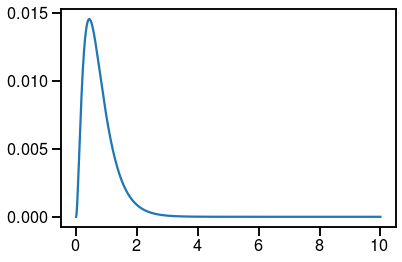

In [17]:
alpha_Y1 = 0.78
z0_Y1 = 0.13
pl.plot(zbins,zbins**2*np.exp(-(zbins/z0_Y1)**alpha_Y1))

In [18]:
nznorm_Y1 = np.trapz(zbins**2*np.exp(-(zbins/z0_Y1)**alpha_Y1),zbins)

In [19]:
nz_Y1 = lambda z:z**2*np.exp(-(z/z0_Y1)**alpha_Y1)/nznorm_Y1

The shear kernel is calculated as follows:

$W_\kappa(\chi)=\frac{3H_0^2\Omega_{m0}}{2c^2}(1+z(\chi))\int d\chi'\,\frac{dz'}{d\chi'}n(z')\frac{\chi(\chi'-\chi)}{\chi'}$

Since we need to work in the basis of comoving distance instead of redshift, we obtain a few interpolation functions and derivatives to calculate this kernel.

In [20]:
chi_to_z = spint.interp1d(cosmo.comoving_distance(zbins).value,zbins,fill_value='extrapolate')
dzdchi = spint.interp1d((zbins[1:]+zbins[:-1])/2,np.diff(zbins)/np.diff(cosmo.comoving_distance(zbins).value),fill_value='extrapolate')(zbins)
chi_to_dzdchi = spint.interp1d(cosmo.comoving_distance(zbins).value,dzdchi,fill_value='extrapolate')
chilim = cosmo.comoving_distance(20).value

In [21]:
Wkappa_chi_Y1 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y1(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)
# units of 1/Mpc in reality

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/4252873278.py:1: RuntimeWarning: invalid value encountered in true_divide
  Wkappa_chi_Y1 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y1(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)


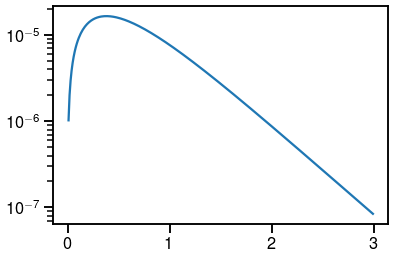

In [22]:
pl.semilogy(zbins[:300],[Wkappa_chi_Y1(chi) for chi in cosmo.comoving_distance(zbins[:300]).value])

What about the intrinsic alignment function?

$W_\text{IA} = -A_\text{IA}C_1\frac{\Omega_{m0}\rho_{c0}}{D(z)}\left(\frac{1+z}{1+z_0}\right)^{\eta_\text{IA}}\frac{dz}{d\chi}n(z)$

So this requires calculation or at least interpolation of the growth factor $D(z)$, which hmf can get for us.

In [23]:
h_for_Dz = hmf.MassFunction()
Dz = []
for z in zbins:
    h_for_Dz.update(z=z)
    Dz.append(h_for_Dz.growth_factor)

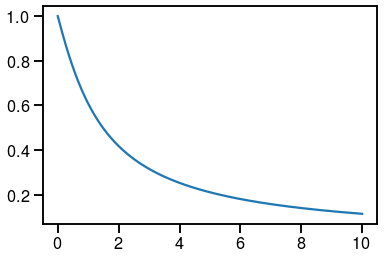

In [24]:
pl.plot(zbins,Dz)

There should be no issue with interpolating this instead of repeatedly calling hmf functions.

In [25]:
Dzinterp = spint.interp1d(zbins,Dz,fill_value='extrapolate')

In [26]:
AIA = 1.
C1 = 5e-14/littleh**2*au.Mpc**3/au.Msun
z0IA = 0.62
etaIA = 3.0

The IA parameters have no dependence on the source density distribution, but the kernel does, so we should distinguish between the IA kernel for LSST Y1 and that for Y10 given the above model:

In [27]:
WIA_chi_Y1 = lambda chi:-AIA*(C1*cosmo.Om0*cosmo.critical_density0/Dzinterp(chi_to_z(chi))*((1+chi_to_z(chi))/(1+z0IA))**etaIA*chi_to_dzdchi(chi)*nz_Y1(chi_to_z(chi))).to(1)
# again actually in units of 1/Mpc

We now repeat the above calculations for a LSST Y10-type source distribution.

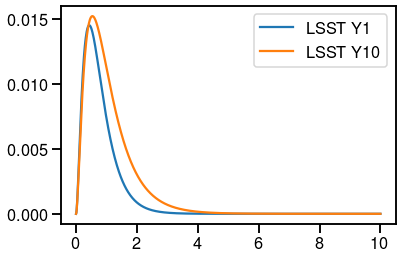

In [28]:
alpha_Y10 = 0.68
z0_Y10 = 0.11
pl.plot(zbins,zbins**2*np.exp(-(zbins/z0_Y1)**alpha_Y1),label='LSST Y1')
pl.plot(zbins,zbins**2*np.exp(-(zbins/z0_Y10)**alpha_Y10),label='LSST Y10')
pl.legend()

In [29]:
nznorm_Y10 = np.trapz(zbins**2*np.exp(-(zbins/z0_Y10)**alpha_Y10),zbins)

In [30]:
nz_Y10 = lambda z:z**2*np.exp(-(z/z0_Y10)**alpha_Y10)/nznorm_Y10

In [31]:
Wkappa_chi_Y10 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y10(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)
WIA_chi_Y10 = lambda chi:-AIA*(C1*cosmo.Om0*cosmo.critical_density0/Dzinterp(chi_to_z(chi))*((1+chi_to_z(chi))/(1+z0IA))**etaIA*chi_to_dzdchi(chi)*nz_Y10(chi_to_z(chi))).to(1)
# again both are supposed to be in units of 1/Mpc

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/4252873278.py:1: RuntimeWarning: invalid value encountered in true_divide
  Wkappa_chi_Y1 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y1(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/2826237776.py:1: RuntimeWarning: invalid value encountered in true_divide
  Wkappa_chi_Y10 = lambda chi:(3*cosmo.H0**2*cosmo.Om0/2/(299792458*au.m/au.s)**2*(1+chi_to_z(chi))*np.trapz(chi_to_dzdchi(np.linspace(chi,chilim,1001))*nz_Y10(chi_to_z(np.linspace(chi,chilim,1001)))*chi*(np.linspace(chi,chilim,1001)-chi)/np.linspace(chi,chilim,1001),np.linspace(chi,chilim,1001))*au.Mpc**2).to(1)


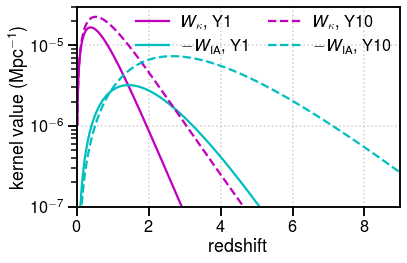

In [32]:
pl.figure().set_tight_layout(True)
pl.semilogy(zbins,[Wkappa_chi_Y1(chi) for chi in cosmo.comoving_distance(zbins).value],'m',label='$W_\\kappa$, Y1')
pl.semilogy(zbins,[-WIA_chi_Y1(chi) for chi in cosmo.comoving_distance(zbins).value],'c',label='$-W_{\\rm IA}$, Y1')
pl.semilogy(zbins,[Wkappa_chi_Y10(chi) for chi in cosmo.comoving_distance(zbins).value],'m--',label='$W_\\kappa$, Y10')
pl.semilogy(zbins,[-WIA_chi_Y10(chi) for chi in cosmo.comoving_distance(zbins).value],'c--',label='$-W_{\\rm IA}$, Y10')
pl.legend(frameon=False,ncol=2,columnspacing=1,borderpad=0)
pl.ylim(1e-7,3e-5)
pl.xlim(0,9)
pl.xlabel('redshift')
pl.ylabel('kernel value (Mpc$^{-1}$)')
pl.grid(True,ls=':',alpha=0.63)
pl.savefig('wl_kernels.png',dpi=288)
pl.savefig('wl_kernels.pdf')

We have now done enough work go ahead and calculate the observed cosmic shear $C_\ell$, including the contribution from IA and shot noise tied to source ellipticities:

In [33]:
sigma_e = 0.26
ng_lens_Y1 = 1.2e8 # sr^{-1}, 10/arcmin^2
ng_lens_Y10 = 3.2e8 # sr^{-1}, 27/arcmin^2

In [34]:
chi_lensint = np.linspace(1,chilim,1001)

This calculation requires us to know the matter power spectrum at each value of $\chi$ being integrated across, and we can interpolate this like we did for $D(z)$:

In [35]:
Pm = []
Plin = []
for z in zbins:
    h_for_Dz.update(z=z)
    Pm.append(spint.interp1d(h_for_Dz.k*littleh,h_for_Dz.nonlinear_power/littleh**3))
    Plin.append(spint.interp1d(h_for_Dz.k*littleh,h_for_Dz.power/littleh**3))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmf/density_field/halofit.py:107: UserWarning: sigma_8 is not used any more, and will be removed in v4
  warnings.warn("sigma_8 is not used any more, and will be removed in v4")


In [36]:
logPm_grid = [np.log10(p(np.logspace(-3,3,6001))) for p in Pm]
logPlin_grid = [np.log10(p(np.logspace(-3,3,6001))) for p in Plin]

In [37]:
Pminterp = spint.RectBivariateSpline(cosmo.comoving_distance(zbins).value,np.linspace(-3,3,6001),logPm_grid)
Plininterp = spint.RectBivariateSpline(cosmo.comoving_distance(zbins).value,np.linspace(-3,3,6001),logPlin_grid)

In [38]:
Cell_lens_tot_Y1 = np.array([np.trapz((Wkappa_chi_Y1(chi_lensint)+WIA_chi_Y1(chi_lensint))**2/\
                                      chi_lensint**2*10**Pminterp(chi_lensint,np.log10(ell/chi_lensint),grid=False),\
                                      chi_lensint) for ell in ellbins]) + sigma_e**2/ng_lens_Y1

In [39]:
Cell_lens_tot_Y10 = np.array([np.trapz((Wkappa_chi_Y10(chi_lensint)+WIA_chi_Y10(chi_lensint))**2/\
                                       chi_lensint**2*10**Pminterp(chi_lensint,np.log10(ell/chi_lensint),grid=False),\
                                       chi_lensint) for ell in ellbins]) + sigma_e**2/ng_lens_Y10

This isn't in the paper, but if you're curious what these shear power spectra look like (with the shape noise subtracted, of course):

(-5e-08, 3.5e-07)

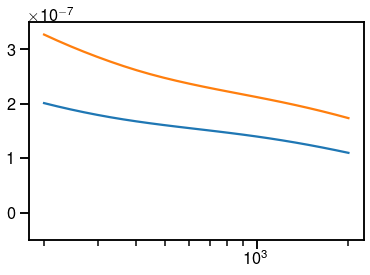

In [40]:
pl.semilogx(ellbins,ellbins*(Cell_lens_tot_Y1-sigma_e**2/ng_lens_Y1))
pl.semilogx(ellbins,ellbins*(Cell_lens_tot_Y10-sigma_e**2/ng_lens_Y10))
pl.ylim(-0.5e-7,3.5e-7)

Finally, while this does not depend on our shear model, we calculate the matter bias that scales the cross spectrum:

In [41]:
h_for_bm = hmf.MassFunction(Mmin=0,dlog10m=0.01)
bm_for_2h = []
bm_for_2h_norm = []
for z in zbins:
    h_for_bm.update(z=z)
    bm_for_2h.append(np.trapz(h_for_bm.dndlog10m*h_for_bm.m/h_for_bm.mean_density0*bofM(h_for_bm),np.log10(h_for_bm.m)))
    bm_for_2h_norm.append(np.trapz(h_for_bm.dndlog10m*h_for_bm.m/h_for_bm.mean_density0,np.log10(h_for_bm.m)))

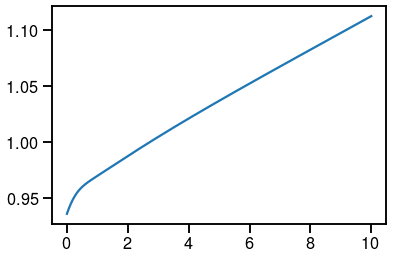

In [42]:
pl.plot(zbins,np.array(bm_for_2h)/np.array(bm_for_2h_norm))

In [43]:
np.max(np.array(bm_for_2h)/np.array(bm_for_2h_norm))

1.1126723029447771

In [44]:
np.min(np.array(bm_for_2h)/np.array(bm_for_2h_norm))

0.9354233444478038

We can also check that the density consistency relation (the integral of the hmf times the halo mass really should equal the mean matter density) fails to even approximately hold at high redshift due to the limitations of our hmf model:

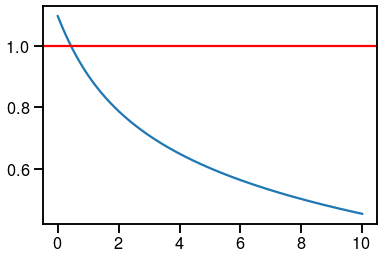

In [45]:
pl.plot(zbins,bm_for_2h_norm)
pl.axhline(1,color='red')

In [46]:
bm_normed_interp = spint.interp1d(zbins,np.array(bm_for_2h)/np.array(bm_for_2h_norm))

## Line-intensity models

In [47]:
CLI = lambda z,nu0:299792458*au.m/au.s/(4.*np.pi*au.sr*nu0*cosmo.H(z))

In [48]:
Js = (3,4,4.27,5,6,7)

Note that $J=4.27$ actually corresponds to CI(1-0) rather than a CO line. We treat the CI line in this way because the Sun+ model scales both the CO lines and the CI line from a model for CO(1-0) luminosity.

In [49]:
rJs = (0.73,0.57,0.18,0.32,0.19,0.1)

In [50]:
CO_CI_label = {J:'CI' if J%1 else J for J in Js}

In [51]:
hmfs_for_CO_CI = {J:{nuobs:hmf.MassFunction(z=115.27*J/nuobs-1) if nuobs < 115.27*J else None for nuobs in nus.value} for J in Js}

In [52]:
hmfs_for_CII = {nuobs:hmf.MassFunction(z=1901.0302/nuobs-1) if nuobs < 1901.0302 else None for nuobs in nus.value}

Pre-defining the hmf objects takes a while, but after this calculating integrated quantities is fairly quick. As an example, here are the cosmic average line intensities for all lines:

In [53]:
I_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/1616487378.py:1: RuntimeWarning: divide by zero encountered in log10
  I_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]


In [54]:
I_CO_CI = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
               np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                        10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*\
                        rJ*J**3,np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value\
              if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

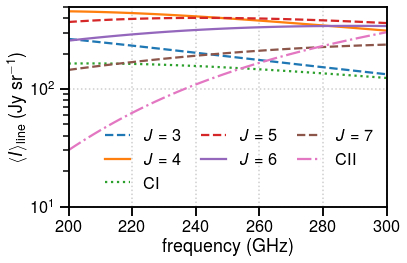

In [55]:
pl.figure().set_tight_layout(True)
for J in Js:
    pl.semilogy(nus.value,I_CO_CI[J],label='{}{}{}'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$'),ls=(':' if J%1 else '-'*(J%2+1)))
pl.semilogy(nus.value,I_CII,label='CII',ls='-.')
pl.grid(True,ls=':',alpha=0.63)
pl.ylim(1e1,5e2)
pl.xlim(200,300)
pl.legend(ncol=3,frameon=False,columnspacing=1.25,handlelength=1.5)
pl.xlabel('frequency (GHz)')
pl.ylabel(r'$\langle I\rangle_\text{line}$ (Jy sr$^{-1}$)')
pl.savefig('Iline.png',dpi=288)
pl.savefig('Iline.pdf')

In [56]:
nus.value[23]

251.08044927153108

In [57]:
[print(CO_CI_label[J],I_CO_CI[J][23]) for J in Js]
print('CII',I_CII[23])

3 187.6817585631142
4 395.83059448768387
CI 151.49920505915767
5 400.26442054255625
6 327.65586232405167
7 202.89384869414351
CII 139.9206177656161


For $C_\ell$, however, the relevant quantity will be the mean intensity-bias product rather than the mean intensity on its own. (There is also the shot noise to consider, although our imposed $\ell_\text{max}$ keeps that minimally relevant.)

In [58]:
Ib_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*bofM(hmfs_for_CII[nuobs])*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/525104734.py:1: RuntimeWarning: divide by zero encountered in log10
  Ib_CII = [(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*np.trapz(hmfs_for_CII[nuobs].dndlog10m*bofM(hmfs_for_CII[nuobs])*10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value for nuobs in nus.value]


In [59]:
Ib_CO_CI = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3,np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

We will also calculate the 3D shot noise, including the enhancement from log-normal scatter.

In [60]:
Pshot_scatter_factor = np.exp((0.4*np.log(10))**2)

In [61]:
Pshot_CII = [Pshot_scatter_factor*(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)**2*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(2*(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34)),np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value for nuobs in nus.value]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/2516000097.py:1: RuntimeWarning: divide by zero encountered in log10
  Pshot_CII = [Pshot_scatter_factor*(CLI(1901.0302/nuobs-1,1901.0302*au.GHz)**2*np.trapz(hmfs_for_CII[nuobs].dndlog10m*10**(2*(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34)),np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value for nuobs in nus.value]


In [62]:
Pshot_CO_CI = {J:[Pshot_scatter_factor*(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*(10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3)**2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

Converting 3D power spectra to angular power spectra requires us to know the comoving shell width corresponding to each channel.

In [63]:
deltachi_CO_CI = {J:np.abs(np.diff(cosmo.comoving_distance(115.27*J/nu_edges-1))) for J in Js}

In [64]:
deltachi_CII = np.abs(np.diff(cosmo.comoving_distance(1901.0302/nu_edges-1)))

In [65]:
EXAMPLE_CHANNEL = 21

In [66]:
Pm_for_CII = [spint.interp1d(hmfs_for_CII[nuobs].k*littleh,hmfs_for_CII[nuobs].power/littleh**3) for nuobs in nus.value]

In [67]:
Pm_for_CO_CI = {J:[spint.interp1d(hmfs_for_CO_CI[J][nuobs].k*littleh,hmfs_for_CO_CI[J][nuobs].power/littleh**3) for nuobs in nus.value] for J in Js}

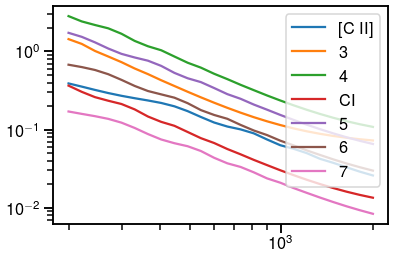

In [68]:
pl.loglog(ellbins,1/deltachi_CII[EXAMPLE_CHANNEL]*(Pshot_CII[EXAMPLE_CHANNEL]+Ib_CII[EXAMPLE_CHANNEL]**2*Pm_for_CII[EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2,label='[C II]')
for J in Js:
    pl.loglog(ellbins,1/deltachi_CO_CI[J][EXAMPLE_CHANNEL]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2*(Pshot_CO_CI[J][EXAMPLE_CHANNEL]+Ib_CO_CI[J][EXAMPLE_CHANNEL]**2*Pm_for_CO_CI[J][EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3,label=CO_CI_label[J])
pl.legend()

We also need LIM x LIM cross spectra for covariance purposes. This is a slightly complex thing, but is tractable. First, we need to establish which channels in which lines overlap with which other channels in which other lines. We may safely exclude CII in this particular context.

In [69]:
Theta_switchertable = {(nu,nu2,J,J2):np.abs(115.27*J/nu-115.27*J2/nu2)<0.5/resolving_power*115.27*(J*J2/(nu*nu2))**0.5 for J in Js for J2 in Js for nu in nus.value for nu2 in nus.value}

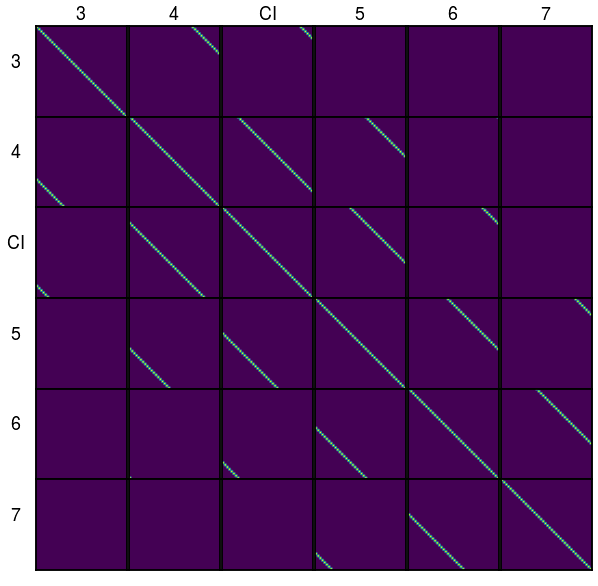

In [70]:
pl.figure(figsize=(10,10))
pl.subplots_adjust(hspace=0.0,wspace=0.0)
for i,J in enumerate(Js):
    for ii,J2 in enumerate(Js):
        pl.subplot(len(Js),len(Js),1+i+ii*len(Js))
        pl.imshow([[Theta_switchertable[(nu1,nu2,J,J2)] for nu1 in nus.value] for nu2 in nus.value])
        if ii==0: pl.title(CO_CI_label[J])
        pl.gca().set_xticks(())
        pl.gca().set_yticks(())
        if i==0: pl.ylabel(CO_CI_label[J2],rotation=0,labelpad=20)

Again, for this purpose we are supposed to calculate total observed $C_\ell$, including noise, but unlike with the lensing $C_\ell$ the signal is insensitive to parameters relevant to noise. So we can calculate the noiseless spectra first and then add noise down the line.

In [71]:
Cell_LIMLIM_noiseless = np.zeros((len(nus.value),len(nus.value),len(ellbins)))
for i,nu in enumerate(nus.value):
    for ii,nu2 in enumerate(nus.value):
        # treating CII as its own special case
        if i==ii:
            Cell_LIMLIM_noiseless[i,ii] += (1/deltachi_CII[i]*(Pshot_CII[i]+Ib_CII[i]**2*\
                        Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nu-1).value))*au.Mpc**3/\
                                    cosmo.comoving_distance(1901.0302/nu-1)**2).to(1).value
        # now iterate through CO and CI using our table for Theta
        for J,rJ in zip(Js,rJs):
            for J2,rJ2 in zip(Js,rJs):
                if Theta_switchertable[(nu,nu2,J,J2)]:
                    deltachi_avg = np.sqrt(deltachi_CO_CI[J][i]*deltachi_CO_CI[J2][ii])
                    chi_avg = np.sqrt(cosmo.comoving_distance(115.27*J/nu-1)*\
                                       cosmo.comoving_distance(115.27*J2/nu2-1))
                    dndlog10m_avg = (hmfs_for_CO_CI[J][nu].dndlog10m+hmfs_for_CO_CI[J2][nu2].dndlog10m)/2
                    LofM_J = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nu-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ*J**3)
                    LofM_J2 = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J2/nu2-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ2*J2**3)
                    Pshot_cross = Pshot_scatter_factor*(CLI(115.27*J/nu-1,115.27*J*au.GHz)*\
                                                        CLI(115.27*J2/nu2-1,115.27*J2*au.GHz)*\
                                        np.trapz(dndlog10m_avg*LofM_J*LofM_J2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*\
                                                        littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value
                    Cell_LIMLIM_noiseless[i,ii] += (1/deltachi_avg/chi_avg**2*\
                        (Pshot_cross+Ib_CO_CI[J][i]*Ib_CO_CI[J2][ii]*\
                         10**Plininterp(np.ones_like(ellbins)*chi_avg.value,np.log10(ellbins/chi_avg.value),\
                                  grid=False))*au.Mpc**3).to(1).value

The first sanity check is whether this calculation lines up for the total auto spectrum in a given channel.

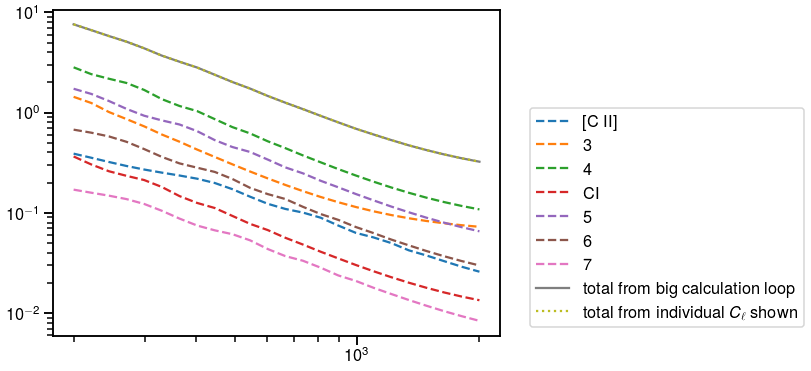

In [72]:
pl.figure(figsize=(8,6))
Cell_CII_for_example_channel = 1/deltachi_CII[EXAMPLE_CHANNEL]*(Pshot_CII[EXAMPLE_CHANNEL]+Ib_CII[EXAMPLE_CHANNEL]**2*Pm_for_CII[EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3/cosmo.comoving_distance((1901.0302*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2
Cell_total_example = 1.*Cell_CII_for_example_channel
pl.loglog(ellbins,Cell_CII_for_example_channel,'--',label='[C II]')
for J in Js:
    Cell_CO_for_example_channel = 1/deltachi_CO_CI[J][EXAMPLE_CHANNEL]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL])**2*(Pshot_CO_CI[J][EXAMPLE_CHANNEL]+Ib_CO_CI[J][EXAMPLE_CHANNEL]**2*Pm_for_CO_CI[J][EXAMPLE_CHANNEL](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[EXAMPLE_CHANNEL]).value))*au.Mpc**3
    pl.loglog(ellbins,Cell_CO_for_example_channel,'--',label=CO_CI_label[J])
    Cell_total_example+= Cell_CO_for_example_channel
pl.loglog(ellbins,Cell_LIMLIM_noiseless[EXAMPLE_CHANNEL,EXAMPLE_CHANNEL],label='total from big calculation loop')
pl.loglog(ellbins,Cell_total_example,':',label='total from individual $C_\ell$ shown')
pl.legend(loc='lower right',bbox_to_anchor=(1.7,0))

Perfect! What do the cross spectra look like?

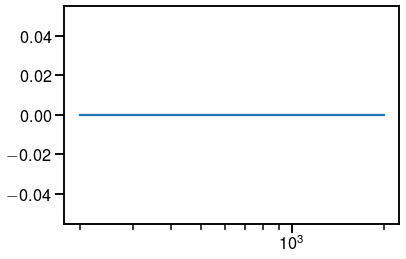

In [73]:
pl.semilogx(ellbins,Cell_LIMLIM_noiseless[21,23])

OK, bad example. There's nothing to cross-correlate positively here. But:

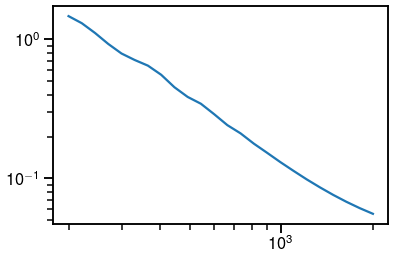

In [74]:
pl.loglog(ellbins,Cell_LIMLIM_noiseless[21,39])

Aha! This pair of channels does have a correlation between $J=5$ and $J=6$.

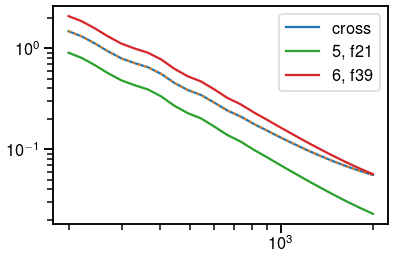

In [75]:
pl.loglog(ellbins,Cell_LIMLIM_noiseless[21,39],label='cross')
pl.loglog(ellbins,Cell_LIMLIM_noiseless[39,21],':')
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]+Ib_CO_CI[3][21]**2*Pm_for_CO_CI[3][21](ellbins/cosmo.comoving_distance((115.27*Js[3]*au.GHz/nus-1)[21]).value))*au.Mpc**3,label='{}, f21'.format(Js[3]))
pl.loglog(ellbins,1/deltachi_CO_CI[4][39]/cosmo.comoving_distance((115.27*Js[4]*au.GHz/nus-1)[39])**2*(Pshot_CO_CI[4][39]+Ib_CO_CI[4][39]**2*Pm_for_CO_CI[4][39](ellbins/cosmo.comoving_distance((115.27*Js[4]*au.GHz/nus-1)[39]).value))*au.Mpc**3,label='{}, f39'.format(Js[4]))
pl.legend()

So the sanity check works in that the cross is roughly in the middle of the two autos (although with enhanced cross shot noise compared to the auto shot noise in either line), and our $C_\ell$ matrix is symmetric between the two frequency dimensions.

## Detectability

We can now input parameters for our mm-wave LIM concepts.

In [76]:
fsky_8sqdeg = 8/41253
fsky_1000sqdeg = 1024/41253 # apologies for the misnomer here

In [77]:
Cell_noise_FYSTlike = 4*np.pi*fsky_8sqdeg*1e6**2/120/4000/3600

Of course, we then have to take into account the frequency-dependence in emissivity and channel bandwidth:

In [78]:
Cell_LIMLIM_FYSTlike = np.diag((emissivity/0.05)**2/(nus.value/resolving_power/2.5)*Cell_noise_FYSTlike)[...,None] + Cell_LIMLIM_noiseless

In [79]:
Cell_cross_Y1 = [sum([np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*(Wkappa_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+WIA_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])+np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*(Wkappa_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+WIA_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2) for i in range(len(nus.value))]

In [80]:
covar_perchannel_FYSTlike_Y1 = [(Cell_LIMLIM_FYSTlike[i,i]*Cell_lens_tot_Y1+Cell_cross_Y1[i]**2)/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))\
                                /fsky_8sqdeg for i in range(len(nus.value))]

In [81]:
print(np.sum(Cell_cross_Y1[EXAMPLE_CHANNEL]**2/covar_perchannel_FYSTlike_Y1[EXAMPLE_CHANNEL])**0.5)

0.3702454450427761


So per-channel signal-to-noise is not looking amazing for LSST Y1 x FYST DSS. This isn't exactly surprising since FYST DSS is geared towards initial detection.

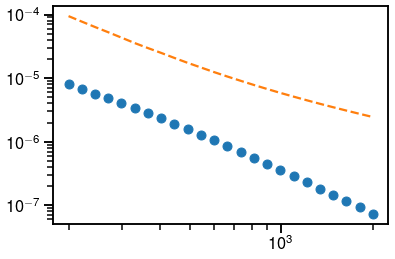

In [82]:
pl.loglog(ellbins,Cell_cross_Y1[EXAMPLE_CHANNEL],'o')
pl.loglog(ellbins,covar_perchannel_FYSTlike_Y1[EXAMPLE_CHANNEL]**0.5,'--')

But what about a Stage 3 LIM experiment?

In [83]:
Cell_noise_CplusS3 = 4*np.pi*fsky_1000sqdeg*1e6**2/15000/12000/3600

In [84]:
Cell_LIMLIM_CplusS3 = np.diag((emissivity/0.05)**2/(nus.value/resolving_power/2.5)*Cell_noise_CplusS3)[...,None] + Cell_LIMLIM_noiseless

In [85]:
Cell_cross_Y10 = [sum([np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])+np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2) for i in range(len(nus.value))]

In [86]:
covar_perchannel_CplusS3_Y10 = [(Cell_LIMLIM_CplusS3[i,i]*Cell_lens_tot_Y10+Cell_cross_Y10[i]**2)/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))\
                                /fsky_1000sqdeg for i in range(len(nus.value))]

In [87]:
print(np.sum(Cell_cross_Y10[EXAMPLE_CHANNEL]**2/covar_perchannel_CplusS3_Y10[EXAMPLE_CHANNEL])**0.5)

11.112923935672375


That is quite high, and is just for one channel!

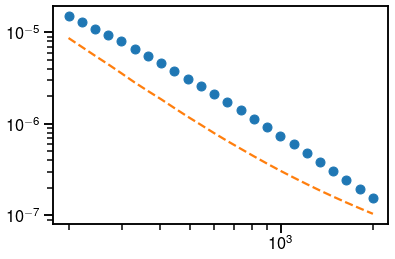

In [88]:
pl.loglog(ellbins,Cell_cross_Y10[EXAMPLE_CHANNEL],'o')
pl.loglog(ellbins,covar_perchannel_CplusS3_Y10[EXAMPLE_CHANNEL]**0.5,'--')

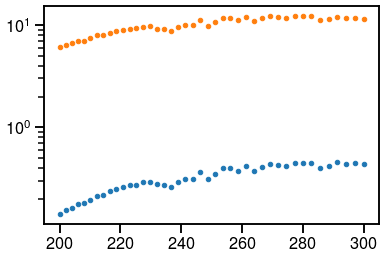

In [89]:
pl.semilogy(nus.value,[(np.sum(Cell_cross_Y1[i]**2/covar_perchannel_FYSTlike_Y1[i])**0.5) for i in range(len(nus.value))],'.')
pl.semilogy(nus.value,[(np.sum(Cell_cross_Y10[i]**2/covar_perchannel_CplusS3_Y10[i])**0.5) for i in range(len(nus.value))],'.')

How does this signal break down by the way? Let's consider $C_{\ell\approx500}$.

In [90]:
Cell_cross_Y10_breakdown = [[np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*\
                                      (Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                       WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*\
                                      Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*\
                                      au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js]+\
                            [np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*\
                                      (Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+\
                                       WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*\
                                      Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*\
                                      au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)] for i in range(len(nus.value))]

In [91]:
ellbins[9]

492.4184802989251

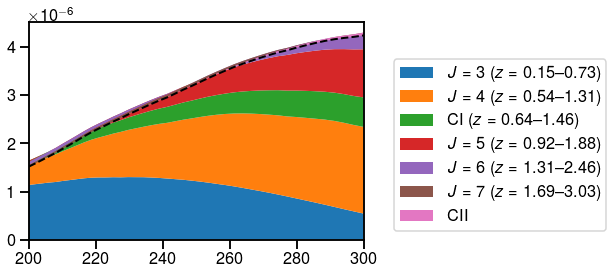

In [92]:
pl.stackplot(nus.value,np.array(Cell_cross_Y10_breakdown)[...,9].T,labels=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$',115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+['CII'])
pl.plot(nus.value,np.array(Cell_cross_Y10)[:,9],'k--',lw=2)
pl.xlim(200,300)
pl.legend(loc='lower right',bbox_to_anchor=(1.75,0))

This doesn't quite line up. What's going on?

In [93]:
np.allclose(np.sum(np.array(Cell_cross_Y10_breakdown)[...,9],axis=1),np.array(Cell_cross_Y10)[:,9])

True

In [94]:
np.sign(np.array(Cell_cross_Y10_breakdown)[:,:,9].T)

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [-1., -1., -1., -1., 

OK, so what's going on is that because the higher-redshift lines all correlate more with IA than with the actual shear, their contribution is negative and that doesn't really play nicely with the plotting here.

Now, the StackOverflow snippet at [https://stackoverflow.com/a/65860277] (CC BY-SA 4.0) has a solution that we adapt:

In [95]:
Cell_cross_Y10_breakdown_pos = np.where(np.array(Cell_cross_Y10_breakdown)>=0,np.array(Cell_cross_Y10_breakdown),0)
Cell_cross_Y10_breakdown_neg = np.where(np.array(Cell_cross_Y10_breakdown)<0,np.array(Cell_cross_Y10_breakdown),0)

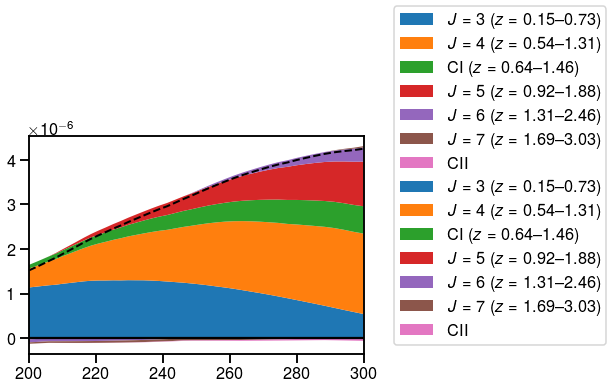

In [96]:
pl.stackplot(nus.value,Cell_cross_Y10_breakdown_pos[...,9].T,labels=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$',115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+['CII'],colors=[pl.cm.tab10(iii) for iii in range(7)])
pl.stackplot(nus.value,Cell_cross_Y10_breakdown_neg[...,9].T,labels=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$',115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+['CII'],colors=[pl.cm.tab10(iii) for iii in range(7)])
pl.plot(nus.value,np.array(Cell_cross_Y10)[:,9],'k--',lw=2)
pl.axhline(0,c='k')
pl.xlim(200,300)
pl.legend(loc='lower right',bbox_to_anchor=(1.75,0))

This still isn't a perfect solution, but at least now you can see that there is a negative contribution and you can eyeball and see that the excess of the stacked positive areas over the true signal is roughly equal to the total from the stacked negative areas.

In [97]:
Cell_cross_Y10_breakdown_noIA = [[np.array(Ib_CO_CI[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js]+[np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*(Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)] for i in range(len(nus.value))]

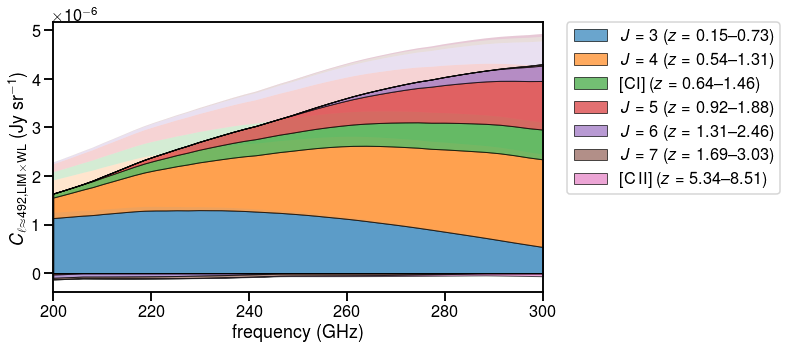

In [98]:
pl.figure(figsize=(17,5))
pl.subplots_adjust(left=0.15,right=0.95,top=0.95,bottom=0.2,hspace=0,wspace=0)
pl.subplot(121)
pl.stackplot(nus.value,np.array(Cell_cross_Y10_breakdown_noIA)[...,9].T,colors=[pl.cm.tab10(iii) for iii in range(7)],alpha=0.2)
pl.stackplot(nus.value,np.array(Cell_cross_Y10_breakdown_pos)[...,9].T,labels=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format(('$J=' if J%1==0 else '['),CO_CI_label[J],('$' if J%1==0 else ']'),115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+[r'[C\textsc{{\,II}}] ($z={:.2f}$--${:.2f}$)'.format(1901.0302/nus.value[-1]-1,1901.0302/nus.value[0]-1)],colors=[pl.cm.tab10(iii) for iii in range(7)],ec='k',lw=1,alpha=0.66)
pl.stackplot(nus.value,np.array(Cell_cross_Y10_breakdown_neg)[...,9].T,colors=[pl.cm.tab10(iii) for iii in range(7)],ec='k',lw=1,alpha=0.66)
pl.axhline(0,c='k',lw=1)
pl.xlim(200,300)
pl.xlabel('frequency (GHz)')
pl.ylabel(r'$C_{\ell\approx492,\text{LIM}\times\text{WL}}$ (Jy sr$^{-1}$)')
pl.legend(loc='lower right',bbox_to_anchor=(1.5,0.33))
pl.savefig('cell_break.png',bbox_inches='tight',dpi=288)
pl.savefig('cell_break.pdf',bbox_inches='tight')

And this isn't in the paper, but here are line plots for the individual contributions:

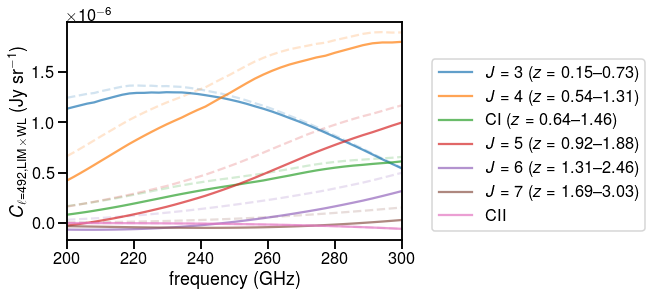

In [99]:
pl.plot(nus.value,np.array(Cell_cross_Y10_breakdown_noIA)[...,9],'--',alpha=0.2)
pl.gca().set_prop_cycle(None)
pl.plot(nus.value,np.array(Cell_cross_Y10_breakdown)[...,9],label=['{}{}{} ($z={:.2f}$--${:.2f}$)'.format((J%1==0)*'$J=',CO_CI_label[J],(J%1==0)*'$',115.27*J/nus.value[-1]-1,115.27*J/nus.value[0]-1) for J in Js]+['CII'],alpha=0.7)
pl.xlim(200,300)
pl.xlabel('frequency (GHz)')
pl.ylabel(r'$C_{\ell=492,\text{LIM}\times\text{WL}}$ (Jy sr$^{-1}$)')
pl.legend(loc='lower right',bbox_to_anchor=(1.75,0))

In [100]:
np.sum((115.27*np.array(Js)[None,:]/nus.value[:,None])*np.array(Cell_cross_Y10_breakdown)[:,:-1,9],axis=-1)/np.array(Cell_cross_Y10)[:,9]-1

array([0.78730911, 0.78794977, 0.78837582, 0.78832621, 0.78832177,
       0.78707655, 0.78527498, 0.78286407, 0.78004722, 0.77702552,
       0.77397891, 0.77102482, 0.76727965, 0.76366441, 0.75902713,
       0.75485701, 0.75033803, 0.74654157, 0.74258546, 0.7386829 ,
       0.73572973, 0.73248476, 0.72938783, 0.72645499, 0.72378628,
       0.72117447, 0.71818543, 0.71549288, 0.71280557, 0.71016308,
       0.70735669, 0.70465507, 0.70182257, 0.69908883, 0.69632883,
       0.69350492, 0.69061367, 0.68770573, 0.68522397, 0.68340976,
       0.68181941, 0.67998293])

It's now time to calculate the overall detection significance across all channels. It helps to define 1D vectors encapsulating all of the $C_\ell$ values from all frequencies:

In [101]:
observable_vector_Y1 = np.hstack(Cell_cross_Y1)

This vector iterates through all $\ell$ before stepping in channel frequency. Like this:

In [102]:
observable_basis = [(nu,ell) for nu in nus.value for ell in ellbins]

In [103]:
observable_basis

[(200.00000000000003, 199.99999999999991),
 (200.00000000000003, 221.05902822520426),
 (200.00000000000003, 244.33546979935838),
 (200.00000000000003, 270.0628075739746),
 (200.00000000000003, 298.49910901036566),
 (200.00000000000003, 329.92961481960384),
 (200.00000000000003, 364.669600173688),
 (200.00000000000003, 403.0675371883465),
 (200.00000000000003, 445.5085903999114),
 (200.00000000000003, 492.4184802989251),
 (200.00000000000003, 544.2677536750615),
 (200.00000000000003, 601.57650360862),
 (200.00000000000003, 664.9195864541883),
 (200.00000000000003, 734.9323881473381),
 (200.00000000000003, 812.3171976753955),
 (200.00000000000003, 897.8502516437208),
 (200.00000000000003, 992.3895206005806),
 (200.00000000000003, 1096.8833152242037),
 (200.00000000000003, 1212.3797986995148),
 (200.00000000000003, 1340.0375007019168),
 (200.00000000000003, 1481.1369384524867),
 (200.00000000000003, 1637.093461413805),
 (200.00000000000003, 1809.4714484698588),
 (200.00000000000003, 1999.

For the near-future scenario, total S/N is marginal at best:

In [104]:
covar_FYSTlike_Y1 = np.array(\
                             [[0 if ell1!=ell2 else \
                      ((Cell_LIMLIM_FYSTlike[np.where(nus.value==nu1)[0][0],np.where(nus.value==nu2)[0][0]]*\
                       Cell_lens_tot_Y1+\
                     Cell_cross_Y1[np.where(nus.value==nu1)[0][0]]*Cell_cross_Y1[np.where(nus.value==nu2)[0][0]]\
                    )/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))/fsky_8sqdeg)[np.where(ellbins==ell1)[0][0]]\
                     for nu1,ell1 in observable_basis]\
                     for nu2,ell2 in observable_basis])

In [105]:
np.matmul(observable_vector_Y1,np.matmul(np.linalg.inv(covar_FYSTlike_Y1),observable_vector_Y1))**0.5

1.828160480138237

But it's a fair bit stronger for the 2030s scenario:

In [106]:
covar_CplusS3_Y10 = np.array(\
                             [[0 if ell1!=ell2 else \
                      ((Cell_LIMLIM_CplusS3[np.where(nus.value==nu1)[0][0],np.where(nus.value==nu2)[0][0]]*\
                       Cell_lens_tot_Y10+\
                     Cell_cross_Y10[np.where(nus.value==nu1)[0][0]]*Cell_cross_Y10[np.where(nus.value==nu2)[0][0]]\
                    )/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))/fsky_1000sqdeg)[np.where(ellbins==ell1)[0][0]]\
                     for nu1,ell1 in observable_basis]\
                     for nu2,ell2 in observable_basis])

In [107]:
observable_vector_Y10 = np.hstack(Cell_cross_Y10)

In [108]:
np.matmul(observable_vector_Y10,np.matmul(np.linalg.inv(covar_CplusS3_Y10),observable_vector_Y10))**0.5

49.609879463928046

All this checks out---roughly on the order of the per-channel S/N scaled by sqrt(Nchan). A re-plot of that just to remind you:

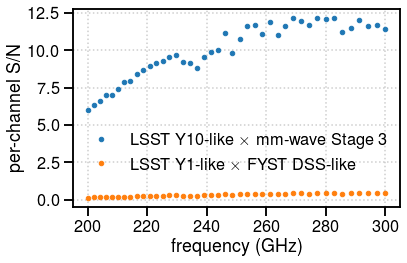

In [109]:
pl.figure().set_tight_layout(True)
pl.plot(nus.value,[(np.sum(Cell_cross_Y10[i]**2/covar_perchannel_CplusS3_Y10[i])**0.5) for i in range(len(nus.value))],'.',label='LSST Y10-like $\\times$ mm-wave Stage 3')
pl.plot(nus.value,[(np.sum(Cell_cross_Y1[i]**2/covar_perchannel_FYSTlike_Y1[i])**0.5) for i in range(len(nus.value))],'.',label='LSST Y1-like $\\times$ FYST DSS-like')
pl.xlabel('frequency (GHz)')
pl.ylabel('per-channel S/N')
pl.legend(loc='lower center',frameon=False,bbox_to_anchor=(0.5,0.1))
pl.grid(ls=':',alpha=0.63)
pl.savefig('sn_perch.pdf')
pl.savefig('sn_perch.png',dpi=288)

Of course, were we not taking off-diagonal covariances into account, we would have ended up with higher S/N:

In [110]:
sum([(np.sum(Cell_cross_Y1[i]**2/covar_perchannel_FYSTlike_Y1[i])) for i in range(len(nus.value))])**0.5

2.210359668185685

In [111]:
sum([(np.sum(Cell_cross_Y10[i]**2/covar_perchannel_CplusS3_Y10[i])) for i in range(len(nus.value))])**0.5

65.64932927477533

## Fisher forecasting

We need to be able to derive the observable vector as a function of model parameters. We'll pick the two parameters controlling the SFR-to-CO(1-0) relation as well as the IA kernel amplitude.

In [112]:
param_labels = ('$\\alpha_\\text{IR--CO}$','$\\beta_\\text{IR--CO}$','$A_\\text{IA}$')

In [113]:
fiducial = (1.27,-1.00,AIA)

In [114]:
prior_widths = np.array((np.inf,np.inf,0.5))

In [115]:
fisher_priors_only = np.diag(prior_widths**-2)

In [116]:
def observable_vector_Y1_recalc(alphaCO,betaCO,AIAnew):
    Ib_CO_CI_recalc = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                           np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                                    10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)\
                                          +9.76-betaCO)/alphaCO-4.31)*rJ*J**3,np.log10(h.m))*\
                           au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value \
                          if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    Pshot_CO_CI_recalc = {J:[Pshot_scatter_factor*\
                             (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*\
                              np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*\
                                       (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1))\
                                              +9.76-betaCO)/alphaCO-4.31)*rJ*J**3)**2,np.log10(h.m))*\
                              au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value \
                             if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    return np.hstack([sum([np.array(Ib_CO_CI_recalc[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*\
                                    (Wkappa_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                  WIA_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)/AIA*AIAnew)/\
                  au.Mpc*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*\
                  au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])\
                      +np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*\
                                (Wkappa_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+\
                                           WIA_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)\
                                          )/au.Mpc*\
                                Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)\
                                *au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)
                      for i in range(len(nus.value))])

In [117]:
np.allclose(observable_vector_Y1_recalc(1.27,-1.00,AIA),observable_vector_Y1)

True

In [118]:
chi_values_CO_CI = [cosmo.comoving_distance(115.27*J/nus.value-1).value for J in Js]
chi_values_CII = cosmo.comoving_distance(1901.0302/nus.value-1).value

In [119]:
Wkappa_Y10_CO_CI = {J:np.array([Wkappa_chi_Y10(cc) for cc in c]) for J,c in zip(Js,chi_values_CO_CI)}
Wkappa_Y10_CII = np.array([Wkappa_chi_Y10(cc) for cc in chi_values_CII])
WIA_Y10_CO_CI = {J:np.array([WIA_chi_Y10(cc) for cc in c]) for J,c in zip(Js,chi_values_CO_CI)}
WIA_Y10_CII = np.array([WIA_chi_Y10(cc) for cc in chi_values_CII])

In [120]:
Pm_precalc_CO_CI = [[Pm_for_CO_CI[J][i](ellbins/chi_values_CO_CI[jj][i]) for i in range(len(nus.value))] for jj,J in enumerate(Js)]
Pm_precalc_CII = [Pm_for_CII[i](ellbins/chi_values_CII[i]) for i in range(len(nus.value))]

In [121]:
def observable_vector_Y10_recalc(alphaCO,betaCO,AIAnew):
    Ib_CO_CI_recalc = {J:[(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                           np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                                    10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)\
                                          +9.76-betaCO)/alphaCO-4.31)*rJ*J**3,np.log10(h.m))*\
                           au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value \
                          if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    Pshot_CO_CI_recalc = {J:[Pshot_scatter_factor*\
                             (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*\
                              np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*\
                                       (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1))\
                                              +9.76-betaCO)/alphaCO-4.31)*rJ*J**3)**2,np.log10(h.m))*\
                              au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value \
                             if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}
    '''
    return np.hstack([sum([np.array(Ib_CO_CI_recalc[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*\
                                    (Wkappa_Y10_CO_CI[J][i]+WIA_Y10_CO_CI[J][i]/AIA*AIAnew)*\
                  Pm_precalc_CO_CI[jj][i]/chi_values_CO_CI[jj][i]**2) for jj,J in enumerate(Js)])\
                      +np.array(Ib_CII[i]*bm_normed_interp(1901.0302/nus.value[i]-1)*\
                                (Wkappa_Y10_CII[i]+WIA_Y10_CII[i]/AIA*AIAnew)*\
                                Pm_precalc_CII[i]/chi_values_CII[i]**2)
                      for i in range(len(nus.value))])

In [122]:
np.allclose(observable_vector_Y10_recalc(1.27,-1.00,AIA),observable_vector_Y10)

True

In [123]:
delta_observable = observable_vector_Y10_recalc(1.27,-1.00,0.9)-observable_vector_Y10
np.exp(-np.matmul(delta_observable,np.matmul(np.linalg.inv(covar_CplusS3_Y10),delta_observable)))

0.1667402332767245

In [124]:
covar_CplusS3_Y10_inv = np.linalg.inv(covar_CplusS3_Y10)

In [362]:
backend = emcee.backends.HDFBackend('emceerun.h5')
backend.reset(32, 3)

In [199]:
def loglik(x):
    delta_observable = observable_vector_Y10_recalc(*x)-observable_vector_Y10
    loglik = -0.5*np.matmul(delta_observable,np.matmul(covar_CplusS3_Y10_inv,delta_observable))
    if np.isnan(loglik) or x[0] < 0.5 or x[0] > 2:
        return -np.inf
    else:
        return loglik#-0.5*(x[-1]-1)**2/0.5**2

Just a bit of system info:

In [366]:
mp.cpu_count() # mp.Pool defaults to having this number of processes

10

In [365]:
print(platform.platform())
print(platform.processor())

macOS-12.0.1-arm64-arm-64bit
arm


In [200]:
sampler = emcee.EnsembleSampler(32,3,loglik,pool=mp.Pool(),backend=backend)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/45905709.py:4: RuntimeWarning: overflow encountered in power
  10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)\
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/45905709.py:17: RuntimeWarning: invalid value encountered in add
  return np.hstack([sum([np.array(Ib_CO_CI_recalc[J][i]*bm_normed_interp(115.27*J/nus.value[i]-1)*\
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/45905709.py:4: RuntimeWarning: overflow encountered in power
  10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)\
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/45905709.py:3: RuntimeWarning: overflow encountered in multiply
  np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/45905709.py:17: RuntimeWarning: invalid value encountered in add
  return np.hstack([sum([np.

In [201]:
pos = np.array(fiducial)[None,:] + 1e-4*np.random.randn(32,3)

In [202]:
sampler.run_mcmc(pos,10000,progress=True)

100%|█████████████████████████████████████| 2000/2000 [1:15:39<00:00,  2.27s/it]


State([[ 1.28039344 -1.10217933  0.98846901]
 [ 1.1805271  -0.2245462   1.1667445 ]
 [ 1.66055486 -4.29010894  0.53486169]
 [ 1.05384605  0.88684757  1.18651716]
 [ 1.71490339 -4.80667115  0.7284906 ]
 [ 1.66787962 -4.40559513  0.68402334]
 [ 1.32519362 -1.4594403   0.75968212]
 [ 1.78278382 -5.37253596  0.72813343]
 [ 1.36311284 -1.80836177  0.81923233]
 [ 1.21111756 -0.47480825  0.96794336]
 [ 1.84941169 -5.91760274  0.47877878]
 [ 1.50672001 -3.03890375  0.8055154 ]
 [ 1.44517066 -2.50391691  0.92206297]
 [ 1.6513095  -4.28966919  0.83380095]
 [ 1.49929818 -2.96465373  0.79883845]
 [ 1.88367981 -6.16686612  0.3221274 ]
 [ 0.98875554  1.47577308  1.2389368 ]
 [ 1.09595213  0.53647294  1.03348572]
 [ 1.3970076  -2.06122174  0.55824031]
 [ 1.41108098 -2.21005094  0.9193727 ]
 [ 1.54138782 -3.28985202  0.56776875]
 [ 1.61008181 -3.91579032  0.74457245]
 [ 1.88510614 -6.21981509  0.5505858 ]
 [ 1.5969946  -3.80188886  0.80904281]
 [ 1.63503806 -4.15428737  1.08003216]
 [ 1.30063236 -1.24

In [204]:
sampler.get_autocorr_time(tol=0)

array([92.60774778, 92.53435023, 84.4519499 ])

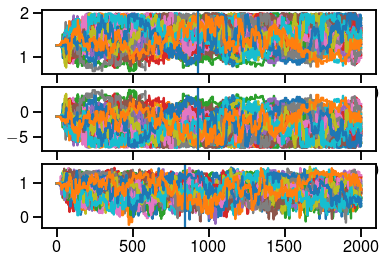

In [207]:
for i in range(3):
    pl.subplot(311+i)
    pl.plot(sampler.get_chain()[...,i])
    pl.axvline(10*sampler.get_autocorr_time(tol=0)[i])

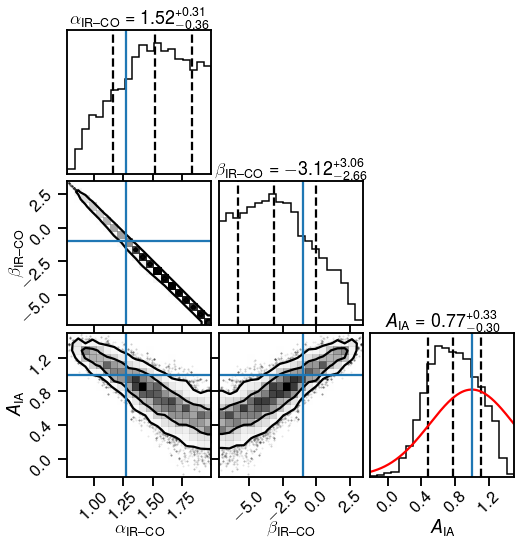

In [328]:
f = corner.corner(sampler.get_chain()[1000:].reshape((-1,3)),labels=param_labels,quantiles=(0.16,0.5,0.84),levels=(0.68,0.95),show_titles=True)
x = np.linspace(f.axes[-1].get_xlim()[0],f.axes[-1].get_xlim()[-1],201)
#f.axes[-1].plot(x,np.exp(-0.5*(x-1)**2/0.25)/np.sqrt(2*np.pi*0.25)*1000*32*np.mean(np.diff(x))*10,'r-')
corner.overplot_lines(f,fiducial)
pl.savefig('emcee_corner.pdf')
pl.savefig('emcee_corner.png',dpi=288)

For the Fisher analysis we estimate the derivative of the observable vector with respect to the three parameters:

In [278]:
FISHER_DPARAM = np.array((0.0001,0.0001,0.0001))

In [279]:
observable_derivatives_Y1 = np.array([(observable_vector_Y1_recalc(*tuple(np.array(fiducial)+FISHER_DPARAM*(np.arange(len(fiducial))==i)))-observable_vector_Y1_recalc(*tuple(np.array(fiducial)-FISHER_DPARAM*(np.arange(len(fiducial))==i)))) for i in range(len(fiducial))])/FISHER_DPARAM[:,None]/2

In [280]:
observable_derivatives_Y10 = np.array([(observable_vector_Y10_recalc(*tuple(np.array(fiducial)+FISHER_DPARAM*(np.arange(len(fiducial))==i)))-observable_vector_Y10_recalc(*tuple(np.array(fiducial)-FISHER_DPARAM*(np.arange(len(fiducial))==i)))) for i in range(len(fiducial))])/FISHER_DPARAM[:,None]/2

And this allows us to calculate the Fisher matrix for both Y1 and Y10.

In [281]:
fisher_Y1 = [[np.matmul(observable_derivatives_Y1[i],np.matmul(np.linalg.inv(covar_FYSTlike_Y1),observable_derivatives_Y1[ii])) for i in range(len(fiducial))] for ii in range(len(fiducial))]
fisher_Y1+= fisher_priors_only

In [282]:
cov_params_Y1 = np.linalg.inv(fisher_Y1)

In [283]:
np.diagonal(cov_params_Y1)**0.5

array([ 4.96135523, 42.84049511,  0.49933223])

In [284]:
fisher_Y10 = [[np.matmul(observable_derivatives_Y10[i],np.matmul(np.linalg.inv(covar_CplusS3_Y10),observable_derivatives_Y10[ii])) for i in range(len(fiducial))] for ii in range(len(fiducial))]
fisher_Y10+= fisher_priors_only

In [285]:
cov_params_Y10 = np.linalg.inv(fisher_Y10)

In [286]:
np.diagonal(cov_params_Y10)**0.5

array([0.36627935, 3.16830581, 0.3553128 ])

In [287]:
cov_params_Y10

array([[ 0.13416056, -1.16046401, -0.12129891],
       [-1.16046401, 10.03816173,  1.04721385],
       [-0.12129891,  1.04721385,  0.12624719]])

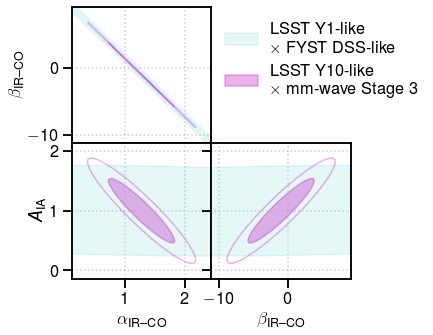

In [288]:
pl.figure(figsize=(5,5))
pl.subplots_adjust(hspace=0,wspace=0)
for i,ilabel in enumerate(param_labels):
    for j,jlabel in enumerate(param_labels):
        if i >= j: continue;
        #pl.subplot(len(fiducial),len(fiducial),j*len(fiducial)+i+1)
        pl.subplot(len(fiducial)-1,len(fiducial)-1,(j-1)*(len(fiducial)-1)+i+1)
        if j < len(fiducial)-1:
            pl.gca().set_xticklabels([])
        else:
            pl.xlabel(ilabel)
        if i > 0:
            pl.gca().set_yticklabels([])
        else:
            if i!=j:
                pl.ylabel(jlabel)
        if i== j:
            '''
            pl.gca().set_yticks([])
            xtmp = np.linspace(fiducial[i]-4.2*cov_params_Y10[i,i]**0.5,fiducial[i]+4.2*cov_params_Y10[i,i]**0.5,101)
            pl.plot(xtmp,np.exp(-(xtmp-fiducial[i])**2/cov_params_Y10[i,i]/2),'m')
            pl.grid(True,axis='x',alpha=0.63,ls=':')
            pl.xlim((fiducial[i]-4.2*cov_params_Y10[i,i]**0.5),fiducial[i]+4.2*cov_params_Y10[i,i]**0.5)
            '''
            continue;
        abp = (cov_params_Y1[i,i]+cov_params_Y1[j,j])/2
        abm = ((cov_params_Y1[i,i]-cov_params_Y1[j,j])**2/4+cov_params_Y1[i,j]*cov_params_Y1[j,i])**0.5
        angle = np.arctan2((cov_params_Y1[i,j]+cov_params_Y1[j,i]),(cov_params_Y1[i,i]-cov_params_Y1[j,j]))/2
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),1.52*2*(abp+abm)**0.5,1.52*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.1,color='c',label='LSST Y1-like\n$\\times$ FYST DSS-like'))
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),2.48*2*(abp+abm)**0.5,2.48*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.1,color='c',fill=False))
        abp = (cov_params_Y10[i,i]+cov_params_Y10[j,j])/2
        abm = ((cov_params_Y10[i,i]-cov_params_Y10[j,j])**2/4+cov_params_Y10[i,j]*cov_params_Y10[j,i])**0.5
        angle = np.arctan2((cov_params_Y10[i,j]+cov_params_Y10[j,i]),(cov_params_Y10[i,i]-cov_params_Y10[j,j]))/2
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),1.52*2*(abp+abm)**0.5,1.52*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.3,color='m',label='LSST Y10-like\n$\\times$ mm-wave Stage 3'))
        pl.gca().add_patch(patches.Ellipse((fiducial[i],fiducial[j]),2.48*2*(abp+abm)**0.5,2.48*2*(abp-abm)**0.5,angle=angle*180/np.pi,alpha=0.3,color='m',fill=False))
        pl.xlim((fiducial[i]-3.2*cov_params_Y10[i,i]**0.5),fiducial[i]+3.2*cov_params_Y10[i,i]**0.5)
        pl.ylim((fiducial[j]-3.2*cov_params_Y10[j,j]**0.5),fiducial[j]+3.2*cov_params_Y10[j,j]**0.5)
        pl.grid(True,alpha=0.63,ls=':')
pl.legend(loc='upper right',frameon=False,bbox_to_anchor=(1.6,2))
pl.savefig('fisherel.pdf',bbox_inches='tight')
pl.savefig('fisherel.png',dpi=288,bbox_inches='tight')

The Fisher analysis broadly agrees with the MCMC in terms of the directions of the parameter degneracies, but seems to underestimate the volume of plausible parameter space.

In both cases there are clear degeneracies at work. I wonder what the IR-CO relation is?

Text(0, 0.5, 'LIR')

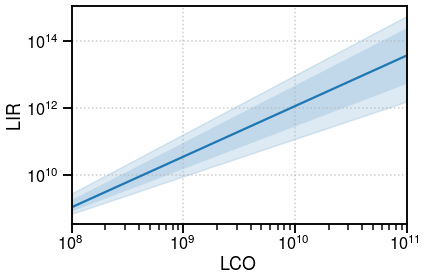

In [234]:
#draw = np.random.multivariate_normal(fiducial[:2],cov_params_Y10[:2,:2],size=10000)
draw = sampler.get_chain()[1000:,:,:2].reshape((-1,2))
LCO = np.logspace(8,11,2)
LIR = 10**(draw[None,:,0]*np.log10(LCO)[:,None]+draw[None,:,1])
pl.loglog(LCO,np.median(LIR,axis=1))
pl.fill_between(LCO,np.percentile(LIR,16,axis=1),np.percentile(LIR,84,axis=1),alpha=0.15)
pl.fill_between(LCO,np.percentile(LIR,2.5,axis=1),np.percentile(LIR,97.5,axis=1),color='C0',alpha=0.15)
pl.grid(True,alpha=0.63,ls=':')
pl.autoscale(tight=True,axis='x')
pl.xlabel('LCO')
pl.ylabel('LIR')

Right, but how does this vary with our power-law parameters?

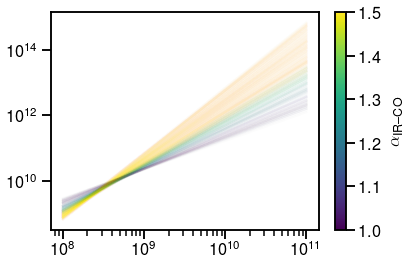

In [235]:
[pl.loglog(LCO,LIR_,c=pl.cm.viridis(alphaIRCO*2-2),alpha=0.01) for LIR_,alphaIRCO in zip(LIR.T[::100],draw[::100,0])]
# thanks to https://stackoverflow.com/a/11558629 (CC BY-SA 4.0) for this snippet of code:
sm = pl.cm.ScalarMappable(cmap=pl.cm.viridis, norm=pl.Normalize(vmin=1, vmax=1.5))
pl.colorbar(sm,label='$\\alpha_\\text{IR--CO}$')

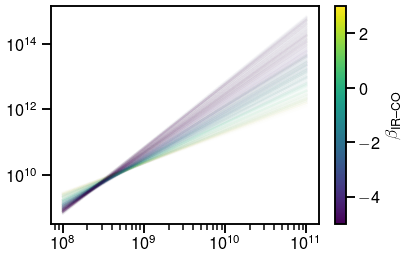

In [236]:
[pl.loglog(LCO,LIR_,c=pl.cm.viridis(betaIRCO*0.125+0.625),alpha=0.01) for LIR_,betaIRCO in zip(LIR.T[::100],draw[::100,1])]
# thanks again to https://stackoverflow.com/a/11558629 (CC BY-SA 4.0) for this snippet of code:
sm = pl.cm.ScalarMappable(cmap=pl.cm.viridis, norm=pl.Normalize(vmin=-5, vmax=3))
pl.colorbar(sm,label='$\\beta_\\text{IR--CO}$')

There is a very strong degeneracy between the two parameters:

In [237]:
np.polyfit(draw[:,0],draw[:,1],1)

array([-8.54230065,  9.87087925])

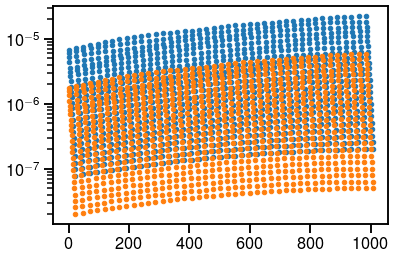

In [238]:
pl.plot(observable_vector_Y10_recalc(1.27,-1,1),'.')
pl.semilogy(observable_vector_Y10_recalc(1.36,-1,1),'.')

So when $\beta_\text{IR--CO}$ is held fixed, increasing $\alpha_\text{IR--CO}$ does in fact decrease the observable signal.

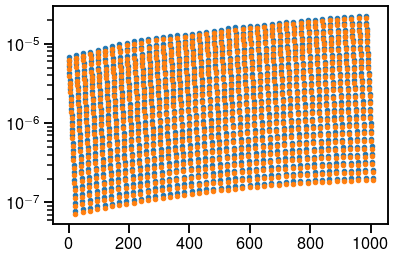

In [239]:
pl.plot(observable_vector_Y10_recalc(1.27,-1,1),'.')
pl.semilogy(observable_vector_Y10_recalc(1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),1),'.')

The degeneracy does means that for the most plausible correlated value of $\beta_\text{IR--CO}$, increasing $\alpha_\text{IR--CO}$ decreases the observable signal a lot less. Nonetheless, it does mean that if the value of $\alpha_\text{IR--CO}$ is higher than the fiducial value, then a lower $A_\text{IA}$ (i.e., less subtraction due to IA) is required to explain the observed signal.

Text(0, 0.5, 'difference from actual signal')

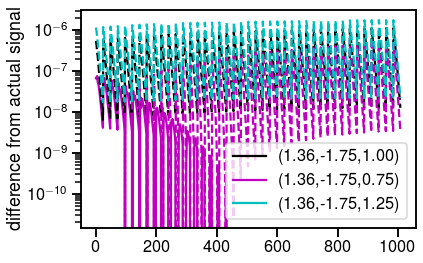

In [240]:
pl.semilogy((observable_vector_Y10_recalc(1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),1)-observable_vector_Y10),c='k')
pl.semilogy((observable_vector_Y10_recalc(1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),0.75)-observable_vector_Y10),c='m')
pl.semilogy((observable_vector_Y10_recalc(1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),1.25)-observable_vector_Y10),c='c')
pl.semilogy(-(observable_vector_Y10_recalc(1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),1)-observable_vector_Y10),'k--')
pl.semilogy(-(observable_vector_Y10_recalc(1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),0.75)-observable_vector_Y10),'m--')
pl.semilogy(-(observable_vector_Y10_recalc(1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),1.25)-observable_vector_Y10),'c--')
pl.legend(['(1.36,{:.2f},{:.2f})'.format(np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),i) for i in (1,0.75,1.25)])
pl.ylabel('difference from actual signal')

In [241]:
loglik((1.27,-1,1))

-1.950791966546982e-30

In [242]:
loglik((1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),1))

-5.294015910728996

In [243]:
loglik((1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),0.75))

-0.8600797187769155

In [244]:
loglik((1.36,np.polyval(np.polyfit(draw[:,0],draw[:,1],1),1.36),1.25))

-18.81425787607046

Actually, while we have this draw, we can use it to get $\rho_\text{H2}$ intervals!

In [245]:
alpha_CO_H2 = 3.6 # Msol per observer integrated luminosity

In [246]:
dndlog10m = []
for z in zbins:
    h_for_Dz.update(z=z)
    dndlog10m.append(h_for_Dz.dndlog10m)

In [247]:
rhoH2_fid = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)\
                                          +9.76-fiducial[1])/fiducial[0]),np.log10(h.m))*littleh**3 for z_,dndlog10m_ in zip(zbins,dndlog10m)]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_44537/1046382591.py:1: RuntimeWarning: divide by zero encountered in log10
  rhoH2_fid = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)\


This is not in the paper but what I think is instructive here is to look at the redshifts corresponding to mid-band observing frequencies for each CO line, and look at the predicted $\rho_\text{H2}$ value as a function of one of the IR--CO parameters.

In [248]:
z_midband = [115.27*J/nus.value[23]-1 for J in Js]

In [249]:
z_midband

[0.37728764228083556,
 0.8363835230411141,
 0.9603394108463892,
 1.295479403801393,
 1.7545752845616711,
 2.2136711653219496]

In [251]:
dndlog10m_zmidband = []
for z in z_midband:
    h_for_Dz.update(z=z)
    dndlog10m_zmidband.append(h_for_Dz.dndlog10m)

In [252]:
rhoH2_draws_midband = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)[None,:]\
                                          +9.76-draw[:,1][:,None])/draw[:,0][:,None]),np.log10(h.m))*littleh**3 for z_,dndlog10m_ in zip(z_midband,dndlog10m_zmidband)]

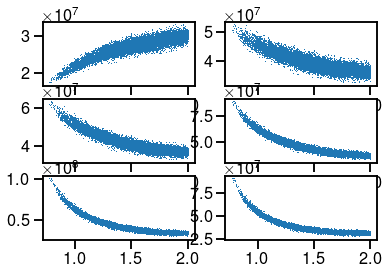

In [253]:
for i in range(len(Js)):
    pl.subplot(321+i)
    pl.plot(draw[:,0],rhoH2_draws_midband[i],',')

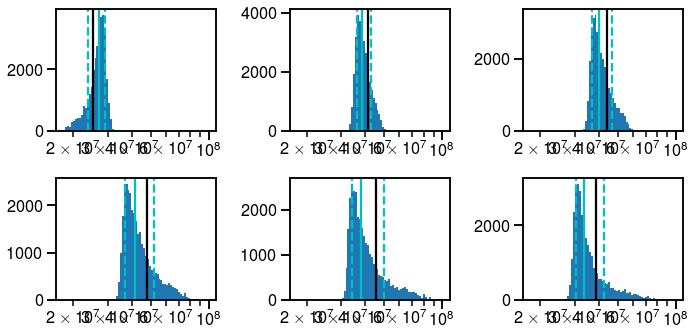

In [254]:
pl.figure(figsize=(10,5)).set_tight_layout(True)
for i in range(len(Js)):
    pl.subplot(231+i)
    pl.hist(rhoH2_draws_midband[i],bins=np.logspace(7.25,8,76))
    pl.axvline(rhoH2_fid[int(z_midband[i]//0.01)],color='k')
    pl.axvline(np.median(rhoH2_draws_midband[i]),color='c')
    pl.axvline(np.percentile(rhoH2_draws_midband[i],16),color='c',ls='--')
    pl.axvline(np.percentile(rhoH2_draws_midband[i],84),color='c',ls='--')
    pl.gca().set_xscale('log')

As you can see the density here is best constrained for the lower redshift CO lines, which makes sense because that's where the lensing kernel is highest and therefore probably where the IR relation is found the best. In fact the higher-redshift constraints are likely best viewed as providing a lower limit, although the 68% CI is consistent with the truth.

In [255]:
np.diff(np.percentile(rhoH2_draws_midband[0],(16,50,84)))

array([3223531.48846702, 1950299.26875822])

In [256]:
np.median(rhoH2_draws_midband[0])

27120448.170847364

In [257]:
rhoH2_fid[int(z_midband[0]//0.01)]

25091228.19414741

In [260]:
np.diff(np.percentile(rhoH2_draws_midband[1],(16,50,84)))

array([2515473.98211728, 4173074.4030816 ])

In [261]:
np.median(rhoH2_draws_midband[1])

38580030.38527856

In [262]:
rhoH2_fid[int(z_midband[1]//0.01)]

41081649.45376902

So for visualising $\rho_\text{H2}$ constraints, let's consider redshifts with particularly high $n(z)$:

(0.0, 1.5)

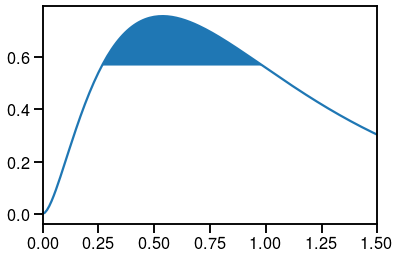

In [361]:
pl.plot(zbins,nz_Y10(zbins))
pl.fill_between(zbins,np.minimum(nz_Y10(zbins),np.max(nz_Y10(zbins))*0.75),nz_Y10(zbins))
pl.xlim(0,1.5)

In [313]:
z_highnz = zbins[np.where(nz_Y10(zbins)>np.max(nz_Y10(zbins))*0.75)]

In [314]:
dndlog10m_z_highnz = []
for z in z_highnz:
    h_for_Dz.update(z=z)
    dndlog10m_z_highnz.append(h_for_Dz.dndlog10m)

In [315]:
rhoH2_draws_z_highnz = [alpha_CO_H2*np.trapz(dndlog10m_*10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,z_)*1.5)[None,:]\
                                          +9.76-draw[:,1][:,None])/draw[:,0][:,None]),np.log10(h.m))*littleh**3 for z_,dndlog10m_ in zip(z_highnz,dndlog10m_z_highnz)]

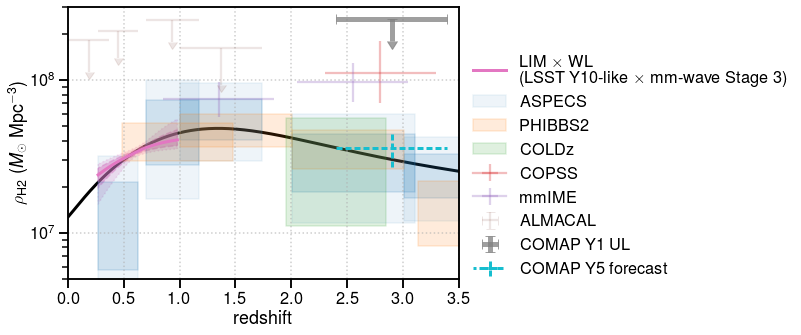

In [316]:
BASE_ALPHA = 0.15
pl.figure(figsize=(7,5))#.set_tight_layout(True)
pl.semilogy(zbins,rhoH2_fid,'k',lw=3,zorder=0)
pl.plot(z_highnz,np.median(rhoH2_draws_z_highnz,axis=-1),'C6',lw=3,label='LIM $\\times$ WL\n(LSST Y10-like $\\times$ mm-wave Stage 3)')
pl.fill_between(z_highnz,*np.percentile(rhoH2_draws_z_highnz,(16,84),axis=-1),color='C6',ls='--',alpha=0.42)
pl.fill_between(z_highnz,*np.percentile(rhoH2_draws_z_highnz,(2.5,97.5),axis=-1),color='C6',ls=':',alpha=0.21)
pl.fill_between((2.008,3.107),(1.164e7,)*2,(6.007e7,)*2,label='ASPECS',alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((2.008,3.107),(1.844e7,)*2,(4.438e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((1.006,1.738),(2.953e7,)*2,(9.462e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((1.006,1.738),(4.053e7,)*2,(7.489e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.003,0.369),(0.002e7,)*2,(0.485e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.003,0.369),(0.015e7,)*2,(0.281e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((3.011,4.475),(1.193e7,)*2,(4.220e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((3.011,4.475),(1.686e7,)*2,(3.289e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.271,0.631),(0.286e7,)*2,(3.181e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.271,0.631),(0.572e7,)*2,(2.148e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.695,1.174),(1.652e7,)*2,(10.02e7,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.695,1.174),(2.772e7,)*2,(7.371e7,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.4799,1.4799),(29.31e6,)*2,(52.38e6,)*2,label='PHIBBS2',alpha=BASE_ALPHA,color='C1')
pl.fill_between((1.0056,2.0056),(36.55e6,)*2,(59.98e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((2.0084,3.0084),(26.27e6,)*2,(46.95e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((3.1404,4.1404),( 8.22e6,)*2,(21.76e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((4.2451,5.2451),( 3.83e6,)*2,(16.58e6,)*2,alpha=BASE_ALPHA,color='C1')
pl.fill_between((1.95,2.85),(1.1e7,1.1e7),(5.6e7,5.6e7),label='COLDz',alpha=BASE_ALPHA,color='C2')
#pl.errorbar(3,2e7,1,label=' ',alpha=0)
pl.errorbar(2.8,1.1e8,yerr=np.array(((0.4,0.7),)).T*1e8,xerr=0.5,label='COPSS',color='C3',alpha=2*BASE_ALPHA)
pl.errorbar(2.55,9.7e7,yerr=np.array(((2.5,3.2),)).T*1e7,xerr=0.5,label='mmIME',color='C4',alpha=2*BASE_ALPHA)
pl.errorbar(1.35,7.5e7,yerr=np.array(((1.8,2.2),)).T*1e7,xerr=0.5,color='C4',alpha=2*BASE_ALPHA)
_,c,_ = pl.errorbar(0.186,10**8.26,yerr=0.7e8,xerr=0.183,uplims=True,label='ALMACAL',color='C5',linestyle='',alpha=BASE_ALPHA)
#c[0].set_alpha(0)
pl.errorbar(0.45095,10**8.32,yerr=0.7e8,xerr=0.17965,uplims=True,color='C5',alpha=BASE_ALPHA)
pl.errorbar(0.9347,10**8.39,yerr=0.7e8,xerr=0.2397,uplims=True,color='C5',alpha=BASE_ALPHA)
pl.errorbar(1.372,10**8.21,yerr=0.7e8,xerr=0.366,uplims=True,color='C5',alpha=BASE_ALPHA)
_,c,_ = pl.errorbar(2.9,2.5e8,yerr=0.7e8,xerr=0.5,uplims=True,label='COMAP Y1 UL',color='C7',lw=5,capsize=5,linestyle='',alpha=5*BASE_ALPHA)
_,c,cc = pl.errorbar(2.9,3.6e7,yerr=0.9e7,xerr=0.5,label='COMAP Y5 forecast',color='C9',lw=3,ls=(1,(2,1)))
cc[0].set_linestyle((0, (2,1)))
cc[1].set_linestyle((0, (2,1)))
'''
_,c,cc = pl.errorbar(2.9,9.0e7,yerr=2.7e7,xerr=0.5,label='Li+2016--Keating+2020',color='C8',lw=2,ls=(1,(2,1)))
pl.errorbar(2.9,9.0e7,yerr=0.47e7,xerr=0.5,label='\\emph{---stronger model assumptions}',color='C9',lw=1,ls=(1,(2,1)),capsize=5)
cc[0].set_linestyle((0, (2,1)))
cc[1].set_linestyle((0, (2,1)))
'''
pl.gca().set_yscale('log')
pl.ylabel('$\\rho_\\text{H2}$ ($M_\\odot$ Mpc$^{-3}$)')
pl.xlabel('redshift')
pl.grid(True,ls=':',alpha=0.63)
pl.xlim(0,3.5)
pl.ylim(5e6,3e8)
pl.legend(loc='lower left',frameon=False,bbox_to_anchor=(1,-0.05))
pl.savefig('rhoH2_illust.pdf',bbox_inches='tight')
pl.savefig('rhoH2_illust.png',bbox_inches='tight',dpi=288)

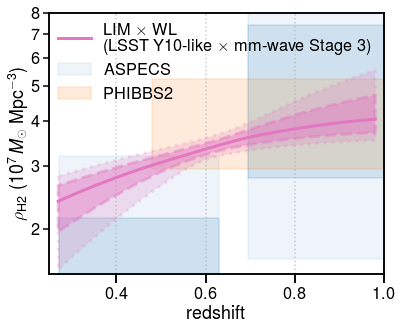

In [360]:
BASE_ALPHA = 0.15
pl.figure(figsize=(6,4.8))#.set_tight_layout(True)
pl.semilogy(zbins,rhoH2_fid,'k',lw=3,zorder=0)
pl.plot(z_highnz,np.median(rhoH2_draws_z_highnz,axis=-1)/1e7,'C6',lw=3,zorder=1000,\
        label='LIM $\\times$ WL\n(LSST Y10-like $\\times$ mm-wave Stage 3)')
pl.fill_between(z_highnz,*np.percentile(rhoH2_draws_z_highnz,(16,84),axis=-1)/1e7,color='C6',lw=3,ls='--',zorder=1000,alpha=0.42)
pl.fill_between(z_highnz,*np.percentile(rhoH2_draws_z_highnz,(2.5,97.5),axis=-1)/1e7,color='C6',lw=3,ls=':',zorder=1000,alpha=0.21)
pl.fill_between((2.008,3.107),(1.164,)*2,(6.007,)*2,label='ASPECS',alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((2.008,3.107),(1.844,)*2,(4.438,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.003,0.369),(0.002,)*2,(0.485,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.003,0.369),(0.015,)*2,(0.281,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.271,0.631),(0.286,)*2,(3.181,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.271,0.631),(0.572,)*2,(2.148,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.695,1.174),(1.652,)*2,(10.02,)*2,alpha=BASE_ALPHA/2,color='C0')
pl.fill_between((0.695,1.174),(2.772,)*2,(7.371,)*2,alpha=BASE_ALPHA,color='C0')
pl.fill_between((0.4799,1.4799),(29.31e-1,)*2,(52.38e-1,)*2,label='PHIBBS2',alpha=BASE_ALPHA,color='C1')
#pl.errorbar(1.35,7.5,yerr=np.array(((1.8,2.2),)).T,xerr=0.5,color='C4',alpha=2*BASE_ALPHA)
#_,c,_ = pl.errorbar(0.186,10**8.26,yerr=0.7e8,xerr=0.183,uplims=True,label='ALMACAL',color='C5',linestyle='',alpha=BASE_ALPHA)
#pl.errorbar(0.45095,10**8.32,yerr=0.7e8,xerr=0.17965,uplims=True,color='C5',alpha=BASE_ALPHA)
#pl.errorbar(0.9347,10**8.39,yerr=0.7e8,xerr=0.2397,uplims=True,color='C5',alpha=BASE_ALPHA)
pl.gca().set_yscale('log')
pl.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter('%d'))
pl.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
pl.ylabel('$\\rho_\\text{H2}$ ($10^7\,M_\\odot$ Mpc$^{-3}$)')
pl.xlabel('redshift')
pl.grid(True,ls=':',alpha=0.63)
pl.xlim(0.25,1.0)
pl.ylim(1.5,8)
pl.legend(loc='upper left',frameon=False,borderpad=0)#,bbox_to_anchor=(1,-0.05))
pl.savefig('rhoH2_illust_detail.pdf',bbox_inches='tight')
pl.savefig('rhoH2_illust_detail.png',bbox_inches='tight',dpi=288)

## An appendix of sorts
Here we're just showing the difference between the linear and nonlinear power spectra, the kmin and kmax corresponding to lmin=200 and lmax=2000 as a function of redshift, and the fact that incorporating the NFW profile makes essentially zero difference to the 2-halo term.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hmf/density_field/halofit.py:107: UserWarning: sigma_8 is not used any more, and will be removed in v4
  warnings.warn("sigma_8 is not used any more, and will be removed in v4")


(100.0, 100000.0)

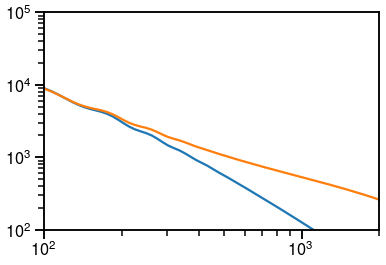

In [156]:
pl.loglog(h.k*littleh*cosmo.comoving_distance(0.5),h.power)
pl.loglog(h.k*littleh*cosmo.comoving_distance(0.5),h.nonlinear_power)
pl.xlim(1e2,2e3)
pl.ylim(1e2,1e5)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/704597843.py:1: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)


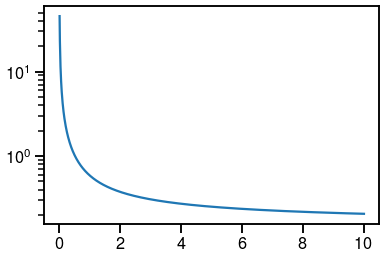

In [157]:
pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/2876375811.py:1: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)


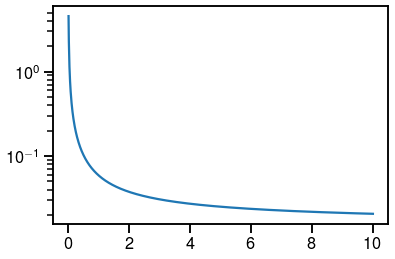

In [158]:
pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3719914040.py:1: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3719914040.py:2: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)


(0.0, 1.0)

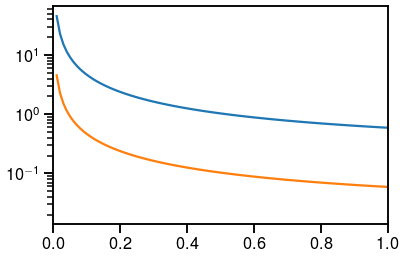

In [159]:
pl.semilogy(zbins,2000/cosmo.comoving_distance(zbins).value)
pl.semilogy(zbins,200/cosmo.comoving_distance(zbins).value)
pl.xlim(0,1)

In [160]:
200/cosmo.comoving_distance(0.15).value

0.31240395097453444

In [161]:
200/cosmo.comoving_distance(8.51).value

0.02153432964014203

In [163]:
kbins = np.logspace(-2,2,401)

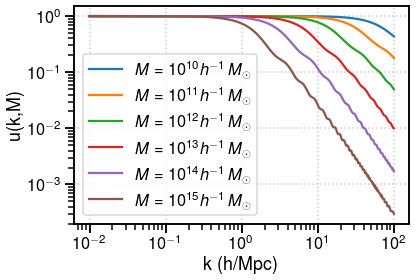

In [164]:
[pl.loglog(kbins,halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(kbins,1e10*10**i)) for i in range(6)]
pl.legend([r'$M=10^{{{}}}h^{{-1}}\,M_\odot$'.format(10+i) for i in range(6)])
pl.xlabel('k (h/Mpc)')
pl.ylabel('u(k,M)')
pl.grid(True,ls=':',alpha=0.63)

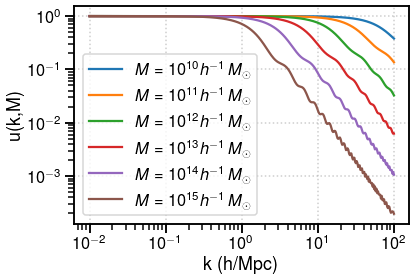

In [165]:
[pl.loglog(kbins,halomod.profiles.NFW(halomod.concentration.Duffy08(),z=2).u(kbins,1e10*10**i)) for i in range(6)]
pl.legend([r'$M=10^{{{}}}h^{{-1}}\,M_\odot$'.format(10+i) for i in range(6)])
pl.xlabel('k (h/Mpc)')
pl.ylabel('u(k,M)')
pl.grid(True,ls=':',alpha=0.63)

Text(0, 0.5, '$u(k=3\\text{ Mpc}^{-1},M_h)$')

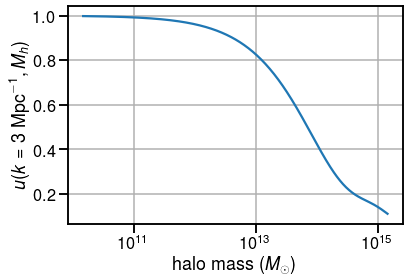

In [166]:
pl.semilogx(h.m/littleh,halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(3/littleh,h.m))
pl.grid(True)
pl.xlabel('halo mass ($M_\\odot$)')
pl.ylabel('$u(k=3\\text{ Mpc}^{-1},M_h)$')

To the best of my understanding, incidentally, $u(k,M)$ is purely real for NFW and does not need to have absolute value signs around it.

In [167]:
halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(3/littleh,1e12)

0.9497635207342418

In [168]:
halomod.profiles.NFW(halomod.concentration.Duffy08(),z=0.2).u(3/littleh,1e13)

0.7800406573259412

In [169]:
Ib_CO_CI_scaledep = {J:[\
                        (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                         np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*bofM(hmfs_for_CO_CI[J][nuobs])*\
                                  halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u(kbins/littleh,h.m)*\
                                  10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3,np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3\
                        ).to(au.Jy/au.sr).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

In [170]:
Ib_CII_scaledep = [\
                   (CLI(1901.0302/nuobs-1,1901.0302*au.GHz)*\
                    np.trapz(hmfs_for_CII[nuobs].dndlog10m*bofM(hmfs_for_CII[nuobs])*\
                             halomod.profiles.NFW(halomod.concentration.Duffy08(),z=1901.0302/nuobs-1).u(kbins/littleh,h.m)*\
                             10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),\
                             np.log10(h.m))*au.Lsun/au.Mpc**3*littleh**3).to(au.Jy/au.sr).value\
                   for nuobs in nus.value]

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/1336257743.py:5: RuntimeWarning: divide by zero encountered in log10
  10**(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nuobs-1)*1.5)+7.34),\


So does this scale-dependent $\langle Ib\rangle(k)$ differ from the scale-independent value by more than 1\% for any lines at any $\ell$?

In [171]:
for ii,J in enumerate(Js):
    Ib_scaledep = [spint.interp1d(kbins,Ib_CO_CI_scaledep[J][i])(ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value) for i in range(len(nus.value))]
    Ib_noscaled = [Ib_CO_CI[J][i] for i in range(len(nus.value))]
    print(np.where(np.abs((np.array(Ib_scaledep)-np.array(Ib_noscaled)[:,None]))/np.array(Ib_noscaled)[:,None]>0.01))

(array([29, 30, 31, 32, 32, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 36,
       37, 37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 40, 40,
       40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41]), array([23, 23, 23, 22, 23, 22, 23, 21, 22, 23, 21, 22, 23, 20, 21, 22, 23,
       20, 21, 22, 23, 19, 20, 21, 22, 23, 18, 19, 20, 21, 22, 23, 18, 19,
       20, 21, 22, 23, 17, 18, 19, 20, 21, 22, 23]))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [172]:
nus[29]

<Quantity 266.42952446 GHz>

Yes, of course it does. Here's the difference for CO(3-2) at 300 GHz:

Text(0.5, 0, '$\\ell$')

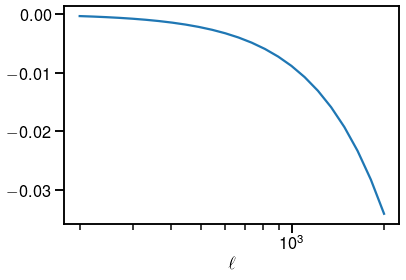

In [173]:
pl.semilogx(ellbins,spint.interp1d(kbins,Ib_CO_CI_scaledep[3][-1])(ellbins/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[-1]).value)/Ib_CO_CI[3][-1]-1)
pl.xlabel('$\\ell$')

But the thing is that this is at very high $\ell$, at which point the shot noise is probably starting to take over.

In [174]:
for ii,J in enumerate(Js):
    Cl_scaledep = [1/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2*(Pshot_CO_CI[J][i]+spint.interp1d(kbins,Ib_CO_CI_scaledep[J][i])(ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value)**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))*au.Mpc**3 for i in range(len(nus.value))]
    Cl_noscaled = [1/deltachi_CO_CI[J][i]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i])**2*(Pshot_CO_CI[J][i]+Ib_CO_CI[J][i]**2*Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value))*au.Mpc**3 for i in range(len(nus.value))]
    print(np.any(np.abs((np.array(Cl_scaledep)-np.array(Cl_noscaled)))/np.array(Cl_noscaled)>0.01))

False
False
False
False
False
False


And indeed it seems like calculating $\langle Ib\rangle$ as scale-dependent does not by itself affect the total $C_\ell$ of each line all that much.

In [175]:
print(np.any(np.abs(\
                    (np.array([spint.interp1d(kbins,Ib_CII_scaledep)(ellbins/cosmo.comoving_distance(1901.0302/nu-1).value) \
                               for nu in nus.value])-np.array(Ib_CII)[:,None])\
                   )/np.array(Ib_CII)[:,None]>0.001))

False


For CII, all differences between $\langle Ib\rangle(\ell)$ and plain $\langle Ib\rangle$ are below 0.1%.

In [176]:
P1h_CO_CI = {J:[\
                (CLI(115.27*J/nuobs-1,115.27*J*au.GHz)**2*\
                 np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*\
                          halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u(ellbins/cosmo.comoving_distance(115.27*J/nuobs-1).value/littleh,h.m)**2*\
                          (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3)**2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3\
                ).to((au.Jy/au.sr)**2*au.Mpc**3).value if nuobs < 115.27*J else np.nan for nuobs in nus.value] for J,rJ in zip(Js,rJs)}

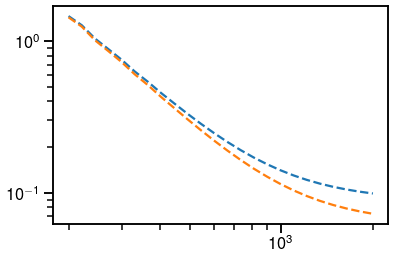

In [177]:
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]+P1h_CO_CI[3][21]+Ib_CO_CI[3][21]**2*Pm_for_CO_CI[3][21](ellbins/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[21]).value))*au.Mpc**3,ls='--')
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]+Ib_CO_CI[3][21]**2*Pm_for_CO_CI[3][21](ellbins/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[21]).value))*au.Mpc**3,ls='--')

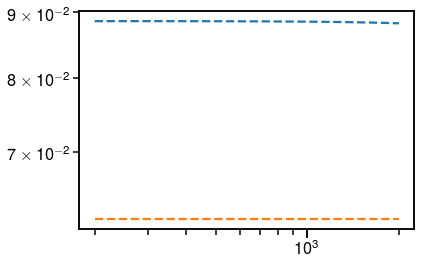

In [178]:
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]+P1h_CO_CI[3][21])*au.Mpc**3,ls='--')
pl.loglog(ellbins,1/deltachi_CO_CI[3][21]/cosmo.comoving_distance((115.27*3*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[3][21]*np.ones_like(ellbins))*au.Mpc**3,ls='--')

I mean, it makes a tiny bit of difference to the auto spectrum? But it's not massive and I suspect it will be damped by the fact that our signal is the cross spectrum and the uncertainty is already rising at high k due to shape noise.

In [179]:
Cell_LIMLIM_with1h = np.zeros((len(nus.value),len(nus.value),len(ellbins)))
for i,nu in enumerate(nus.value):
    for ii,nu2 in enumerate(nus.value):
        # treating CII as its own special case
        if i==ii:
            Cell_LIMLIM_with1h[i,ii] += (1/deltachi_CII[i]*(Pshot_CII[i]+\
                        (CLI(1901.0302/nu-1,1901.0302*au.GHz)**2*\
                         np.trapz(hmfs_for_CII[nu].dndlog10m*\
                                  halomod.profiles.NFW(halomod.concentration.Duffy08(),\
                                                       z=1901.0302/nu-1).u(ellbins/cosmo.comoving_distance(1901.0302/nu-1).value/littleh,h.m)**2*\
                                  10**(2*(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nu-1)*1.5)+7.34)),\
                                  np.log10(h.m))*au.Lsun**2/au.Mpc**3*littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value+\
                        spint.interp1d(kbins,Ib_CII_scaledep[i])(ellbins/cosmo.comoving_distance(1901.0302/nu-1).value)**2*\
                        Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nu-1).value))*au.Mpc**3/\
                                    cosmo.comoving_distance(1901.0302/nu-1)**2).to(1).value
        # now iterate through CO and CI using our table for Theta
        for J,rJ in zip(Js,rJs):
            for J2,rJ2 in zip(Js,rJs):
                if Theta_switchertable[(nu,nu2,J,J2)]:
                    deltachi_avg = np.sqrt(deltachi_CO_CI[J][i]*deltachi_CO_CI[J2][ii])
                    chi_avg = np.sqrt(cosmo.comoving_distance(115.27*J/nu-1)*\
                                       cosmo.comoving_distance(115.27*J2/nu2-1))
                    dndlog10m_avg = (hmfs_for_CO_CI[J][nu].dndlog10m+hmfs_for_CO_CI[J2][nu2].dndlog10m)/2
                    LofM_J = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nu-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ*J**3)
                    LofM_J2 = (10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J2/nu2-1)*1.5)+\
                                                10.76)/1.27-4.31)*rJ2*J2**3)
                    Pshot_cross = Pshot_scatter_factor*(CLI(115.27*J/nu-1,115.27*J*au.GHz)*\
                                                        CLI(115.27*J2/nu2-1,115.27*J2*au.GHz)*\
                                        np.trapz(dndlog10m_avg*LofM_J*LofM_J2,np.log10(h.m))*au.Lsun**2/au.Mpc**3*\
                                                        littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value
                    P1h_cross = (CLI(115.27*J/nu-1,115.27*J*au.GHz)*CLI(115.27*J2/nu2-1,115.27*J2*au.GHz)*\
                                        np.trapz(dndlog10m_avg*LofM_J*LofM_J2*\
                                                 halomod.profiles.NFW(halomod.concentration.Duffy08(),\
                                                                      z=chi_to_z(chi_avg)\
                                                                     ).u(ellbins/chi_avg.value/littleh,h.m)**2,\
                                                 np.log10(h.m))*au.Lsun**2/au.Mpc**3*\
                                                        littleh**3).to((au.Jy/au.sr)**2*au.Mpc**3).value
                    Cell_LIMLIM_with1h[i,ii] += (1/deltachi_avg/chi_avg**2*\
                        (Pshot_cross+P1h_cross+\
                         spint.interp1d(kbins,Ib_CO_CI_scaledep[J][i])(ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value)*\
                         spint.interp1d(kbins,Ib_CO_CI_scaledep[J2][ii])(ellbins/cosmo.comoving_distance((115.27*J2*au.GHz/nus-1)[ii]).value)*\
                         10**Plininterp(np.ones_like(ellbins)*chi_avg.value,np.log10(ellbins/chi_avg.value),\
                                  grid=False))*au.Mpc**3).to(1).value

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/4274193620.py:11: RuntimeWarning: divide by zero encountered in log10
  10**(2*(np.log10(unimachsfr.sfr_from_Mh((h.m/littleh),1901.0302/nu-1)*1.5)+7.34)),\


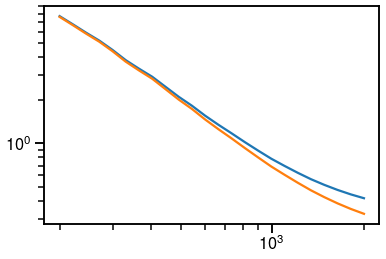

In [180]:
pl.loglog(ellbins,Cell_LIMLIM_with1h[21,21])
pl.loglog(ellbins,Cell_LIMLIM_noiseless[21,21])

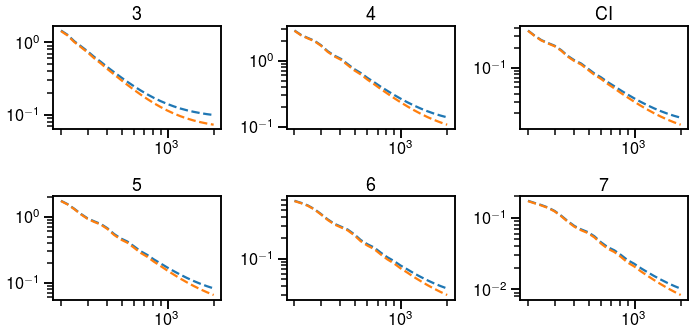

In [181]:
pl.figure(figsize=(10,5)).set_tight_layout(True)
for i,J in enumerate(Js):
    pl.subplot(231+i)
    pl.title(CO_CI_label[J])
    pl.loglog(ellbins,1/deltachi_CO_CI[J][21]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[J][21]+P1h_CO_CI[J][21]+Ib_CO_CI[J][21]**2*Pm_for_CO_CI[J][21](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[21]).value))*au.Mpc**3,ls='--')
    pl.loglog(ellbins,1/deltachi_CO_CI[J][21]/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[21])**2*(Pshot_CO_CI[J][21]+Ib_CO_CI[J][21]**2*Pm_for_CO_CI[J][21](ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[21]).value))*au.Mpc**3,ls='--')

In [182]:
np.nanmax(Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/1256455144.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.nanmax(Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1)


0.33570148918007403

In [183]:
np.nanmin(Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1)

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3079355670.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.nanmin(Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1)


0.009698546405464636

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/2757946162.py:1: RuntimeWarning: invalid value encountered in true_divide
  pl.hist((Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1).flatten(),bins=np.linspace(0,0.34,35))


(array([  68., 1434.,  824.,  540.,  425.,  346.,  301.,  254.,  241.,
         185.,  199.,  195.,  154.,  174.,  140.,  163.,  125.,  155.,
         120.,  145.,  134.,  120.,  151.,  115.,  155.,  113.,  107.,
          82.,   54.,   49.,   30.,   32.,    8.,    6.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34]),
 <BarContainer object of 34 artists>)

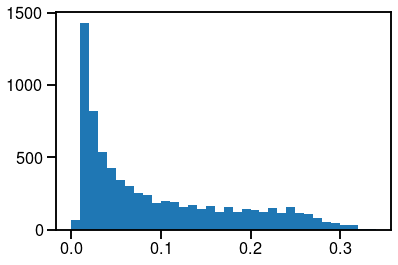

In [184]:
pl.hist((Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1).flatten(),bins=np.linspace(0,0.34,35))

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3226687229.py:1: RuntimeWarning: invalid value encountered in true_divide
  pl.pcolormesh(ellbins,nus.value,[(Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1)[i,i] for i in range(len(nus.value))],cmap=pl.cm.Greys,vmin=0)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3226687229.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(ellbins,nus.value,[(Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1)[i,i] for i in range(len(nus.value))],cmap=pl.cm.Greys,vmin=0)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3226687229.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().xaxis.set_mino

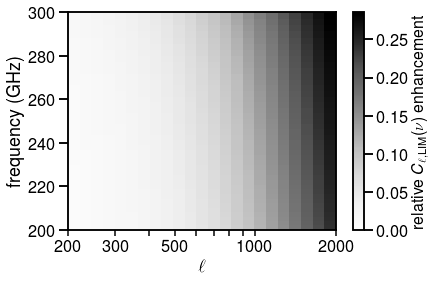

In [185]:
pl.pcolormesh(ellbins,nus.value,[(Cell_LIMLIM_with1h/Cell_LIMLIM_noiseless-1)[i,i] for i in range(len(nus.value))],cmap=pl.cm.Greys,vmin=0)
pl.gca().set_xscale('log')
pl.gca().xaxis.set_minor_formatter(ticker.FixedFormatter(('200','300','','500','','','','','1000','2000')))
pl.gca().xaxis.set_minor_locator(ticker.FixedLocator(tuple(np.arange(2,11)*100)+(2000,)))
pl.gca().xaxis.set_major_locator(ticker.NullLocator())
pl.xlabel('$\ell$')
pl.ylabel('frequency (GHz)')
pl.colorbar().set_label(r'relative $C_{\ell,\text{LIM}}(\nu)$ enhancement',fontsize=16)
pl.savefig('limdiag_1hadd.png',bbox_inches='tight',dpi=288)
pl.savefig('limdiag_1hadd.pdf',bbox_inches='tight')

OK, we've calculated the LIM auto and LIM--LIM cross spectra including the 1-halo term. Now moving on to LIM--WL ...

In [186]:
h.mean_density0*littleh**2

39161183744.6803

In [187]:
(cosmo.Om0*cosmo.critical_density0).to(au.Msun/au.Mpc**3)

<Quantity 3.91611837e+10 solMass / Mpc3>

In [188]:
bm_for_2h_scaledep = []
for z in zbins:
    h_for_bm.update(z=z)
    bm_for_2h_scaledep.append(np.trapz(h_for_bm.dndlog10m*h_for_bm.m/h_for_bm.mean_density0*bofM(h_for_bm)*halomod.profiles.NFW(halomod.concentration.Duffy08(),z=z).u(kbins[None,:]/littleh,h_for_bm.m),np.log10(h_for_bm.m)))

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/1115167297.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(kbins,zbins,np.array(bm_for_2h_scaledep)/np.array(bm_for_2h)[:,None])
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/1115167297.py:2: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogx(2000/cosmo.comoving_distance(zbins).value,zbins)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/1115167297.py:3: RuntimeWarning: divide by zero encountered in true_divide
  pl.semilogx(200/cosmo.comoving_distance(zbins).value,zbins)


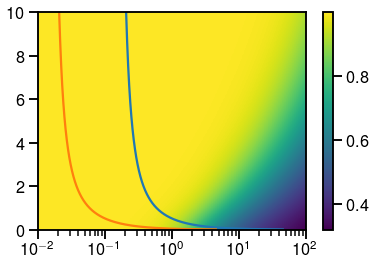

In [189]:
pl.pcolormesh(kbins,zbins,np.array(bm_for_2h_scaledep)/np.array(bm_for_2h)[:,None])
pl.semilogx(2000/cosmo.comoving_distance(zbins).value,zbins)
pl.semilogx(200/cosmo.comoving_distance(zbins).value,zbins)
pl.gca().set_xscale('log')
pl.colorbar()

In principle, given the relevant ranges of redshift and $k$, the NFW profile should not introduce significant scale-dependence in the matter bias in this context.

In [190]:
bm_normed_scaledep_interp = spint.RectBivariateSpline(zbins,kbins,np.array(bm_for_2h_scaledep)/np.array(bm_for_2h_norm)[:,None])

In [191]:
Cell_cross_Y1_2h_scaledep = [sum([np.array(spint.interp1d(kbins,Ib_CO_CI_scaledep[J][i])(ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value)*\
                                           bm_normed_scaledep_interp(115.27*J/nus.value[i]-1,ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value,grid=False)*\
                               (Wkappa_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                WIA_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*\
                               Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*\
                               au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])+\
                 np.array(spint.interp1d(kbins,Ib_CII_scaledep[i])(ellbins/cosmo.comoving_distance(1901.0302/nu-1).value)*\
                          bm_normed_scaledep_interp(1901.0302/nus.value[i]-1,ellbins/cosmo.comoving_distance(1901.0302/nu-1).value,grid=False)*\
                          (Wkappa_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+\
                           WIA_chi_Y1(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*\
                          Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*\
                          au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)\
                 for i in range(len(nus.value))]

In [192]:
np.max(np.abs(np.array(Cell_cross_Y1_2h_scaledep)/np.array(Cell_cross_Y1)-1))

0.0757372210079682

(array([  0.,   2.,   2.,   2.,   2.,   4.,   4.,   3.,   5.,   6.,   5.,
          7.,   8.,   5.,  10.,   9.,  11.,  12.,  14.,  18.,  17.,  21.,
         26.,  25.,  32.,  36.,  42.,  51.,  62.,  90., 157., 320.]),
 array([-0.08  , -0.0775, -0.075 , -0.0725, -0.07  , -0.0675, -0.065 ,
        -0.0625, -0.06  , -0.0575, -0.055 , -0.0525, -0.05  , -0.0475,
        -0.045 , -0.0425, -0.04  , -0.0375, -0.035 , -0.0325, -0.03  ,
        -0.0275, -0.025 , -0.0225, -0.02  , -0.0175, -0.015 , -0.0125,
        -0.01  , -0.0075, -0.005 , -0.0025,  0.    ]),
 <BarContainer object of 32 artists>)

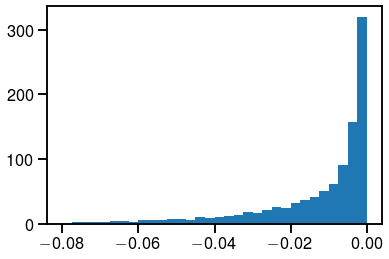

In [193]:
pl.hist((np.array(Cell_cross_Y1_2h_scaledep)/np.array(Cell_cross_Y1)-1).flatten(),bins=np.linspace(-0.08,0,33))

OK, so a change of at most 8\% before the 1-halo term is introduced ...

In [194]:
Cell_cross_Y10_2h_scaledep = [sum([np.array(spint.interp1d(kbins,Ib_CO_CI_scaledep[J][i])(ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value)*\
                                           bm_normed_scaledep_interp(115.27*J/nus.value[i]-1,ellbins/cosmo.comoving_distance((115.27*J*au.GHz/nus-1)[i]).value,grid=False)*\
                               (Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*\
                               Pm_for_CO_CI[J][i](ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)*\
                               au.Mpc**3/cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2) for J in Js])+\
                 np.array(spint.interp1d(kbins,Ib_CII_scaledep[i])(ellbins/cosmo.comoving_distance(1901.0302/nu-1).value)*\
                          bm_normed_scaledep_interp(1901.0302/nus.value[i]-1,ellbins/cosmo.comoving_distance(1901.0302/nu-1).value,grid=False)*\
                          (Wkappa_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)+\
                           WIA_chi_Y10(cosmo.comoving_distance(1901.0302/nus.value[i]-1).value))/au.Mpc*\
                          Pm_for_CII[i](ellbins/cosmo.comoving_distance(1901.0302/nus.value[i]-1).value)*\
                          au.Mpc**3/cosmo.comoving_distance(1901.0302/nus.value[i]-1)**2)\
                 for i in range(len(nus.value))]

In [195]:
np.max(np.abs(np.array(Cell_cross_Y10_2h_scaledep)/np.array(Cell_cross_Y10)-1))

0.05460165410418516

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,
          3.,   3.,   5.,   5.,   7.,   7.,   9.,   9.,  14.,  13.,  17.,
         20.,  25.,  31.,  33.,  44.,  51.,  68.,  92., 158., 391.]),
 array([-0.08  , -0.0775, -0.075 , -0.0725, -0.07  , -0.0675, -0.065 ,
        -0.0625, -0.06  , -0.0575, -0.055 , -0.0525, -0.05  , -0.0475,
        -0.045 , -0.0425, -0.04  , -0.0375, -0.035 , -0.0325, -0.03  ,
        -0.0275, -0.025 , -0.0225, -0.02  , -0.0175, -0.015 , -0.0125,
        -0.01  , -0.0075, -0.005 , -0.0025,  0.    ]),
 <BarContainer object of 32 artists>)

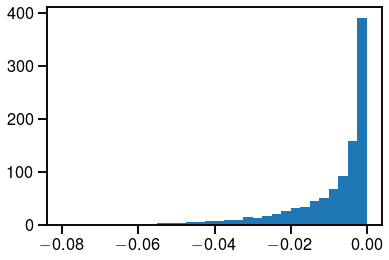

In [196]:
pl.hist((np.array(Cell_cross_Y10_2h_scaledep)/np.array(Cell_cross_Y10)-1).flatten(),bins=np.linspace(-0.08,0,33))

... and even less once we start leaning on higher-redshift data with Y10.

In [197]:
Cell_cross_Y1_1h = [sum(\
                         [(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                                   (Wkappa_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                    WIA_chi_Y1(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*\
                                   np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*h.m/h.mean_density0*\
                                            10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3*
                                   halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u((ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)/littleh,h.m)**2,\
                                            np.log10(h.m))*au.Lsun/\
                                   cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2).to(au.Jy/au.sr).value for J in Js])\
                     for i,nuobs in enumerate(nus.value)\
                    ]

In [198]:
Cell_cross_Y10_1h = [sum(\
                         [(CLI(115.27*J/nuobs-1,115.27*J*au.GHz)*\
                                   (Wkappa_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)+\
                                    WIA_chi_Y10(cosmo.comoving_distance(115.27*J/nus.value[i]-1).value))/au.Mpc*\
                                   np.trapz(hmfs_for_CO_CI[J][nuobs].dndlog10m*h.m/h.mean_density0*\
                                            10**((np.log10(unimachsfr.sfr_from_Mh(h.m/littleh,115.27*J/nuobs-1)*1.5)+10.76)/1.27-4.31)*rJ*J**3*
                                   halomod.profiles.NFW(halomod.concentration.Duffy08(),z=115.27*J/nuobs-1).u((ellbins/cosmo.comoving_distance(115.27*J/nus.value[i]-1).value)/littleh,h.m)**2,\
                                            np.log10(h.m))*au.Lsun/\
                                   cosmo.comoving_distance(115.27*J/nus.value[i]-1)**2).to(au.Jy/au.sr).value for J in Js])\
                     for i,nuobs in enumerate(nus.value)\
                    ]

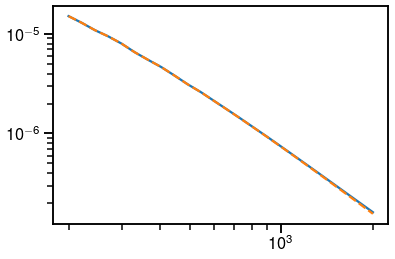

In [199]:
pl.loglog(ellbins,Cell_cross_Y10_2h_scaledep[EXAMPLE_CHANNEL]+Cell_cross_Y10_1h[EXAMPLE_CHANNEL])
pl.loglog(ellbins,Cell_cross_Y10[EXAMPLE_CHANNEL],'--')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 517., 115.,  64.,  47.,  33.,
         27.,  27.,  17.,  21.,  15.,  16.,  13.,  13.,   8.,   9.,   7.,
          7.,   6.,   3.,   5.,   4.,   3.,   3.,   3.,   2.,   2.,   3.,
          1.,   2.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,
          0.]),
 array([-0.1  , -0.098, -0.096, -0.094, -0.092, -0.09 , -0.088, -0.086,
        -0.084, -0.082, -0.08 , -0.078, -0.076, -0.074, -0.072, -0.07 ,
        -0.068, -0.066, -0.064, -0.062, -0.06 , -0.058, -0.056, -0.054,
        -0.052, -0.05 , -0.048, -0.046, -0.044, -0.042, -0.04 , -0.038,
        -0.036, -0.034, -0.032

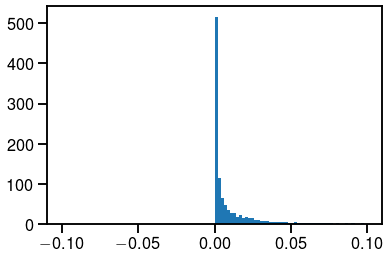

In [200]:
pl.hist(((np.array(Cell_cross_Y10_2h_scaledep)+np.array(Cell_cross_Y10_1h))/np.array(Cell_cross_Y10)-1).flatten(),bins=np.linspace(-0.1,0.1,101))

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3212228246.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(ellbins,nus.value,(np.array(Cell_cross_Y10_2h_scaledep)+np.array(Cell_cross_Y10_1h))/np.array(Cell_cross_Y10)-1,cmap=pl.cm.Greys,vmin=0)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3212228246.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().xaxis.set_minor_formatter(ticker.FixedFormatter(('200','300','','500','','','','','1000','2000')))


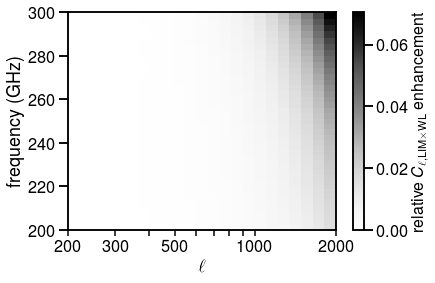

In [201]:
pl.pcolormesh(ellbins,nus.value,(np.array(Cell_cross_Y10_2h_scaledep)+np.array(Cell_cross_Y10_1h))/np.array(Cell_cross_Y10)-1,cmap=pl.cm.Greys,vmin=0)
pl.gca().set_xscale('log')
pl.gca().xaxis.set_minor_formatter(ticker.FixedFormatter(('200','300','','500','','','','','1000','2000')))
pl.gca().xaxis.set_minor_locator(ticker.FixedLocator(tuple(np.arange(2,11)*100)+(2000,)))
pl.gca().xaxis.set_major_locator(ticker.NullLocator())
pl.xlabel('$\ell$')
pl.ylabel('frequency (GHz)')
pl.colorbar().set_label(r'relative $C_{\ell,\text{LIM}\times\text{WL}}$ enhancement',fontsize=16)
pl.savefig('limwl_1hadd.png',bbox_inches='tight',dpi=288)
pl.savefig('limwl_1hadd.pdf',bbox_inches='tight')

/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3672907334.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(ellbins,nus.value,(np.array(Cell_cross_Y1_2h_scaledep)+np.array(Cell_cross_Y1_1h))/np.array(Cell_cross_Y1)-1,cmap=pl.cm.Greys,vmin=0)
/var/folders/v3/x51gcb_n2vxdgxtr8mm7yrz00000gn/T/ipykernel_43644/3672907334.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().xaxis.set_minor_formatter(ticker.FixedFormatter(('200','300','','500','','','','','1000','2000')))


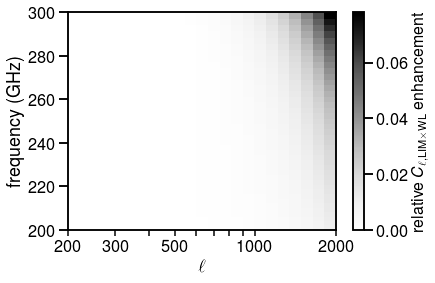

In [202]:
pl.pcolormesh(ellbins,nus.value,(np.array(Cell_cross_Y1_2h_scaledep)+np.array(Cell_cross_Y1_1h))/np.array(Cell_cross_Y1)-1,cmap=pl.cm.Greys,vmin=0)
pl.gca().set_xscale('log')
pl.gca().xaxis.set_minor_formatter(ticker.FixedFormatter(('200','300','','500','','','','','1000','2000')))
pl.gca().xaxis.set_minor_locator(ticker.FixedLocator(tuple(np.arange(2,11)*100)+(2000,)))
pl.gca().xaxis.set_major_locator(ticker.NullLocator())
pl.xlabel('$\ell$')
pl.ylabel('frequency (GHz)')
pl.colorbar().set_label(r'relative $C_{\ell,\text{LIM}\times\text{WL}}$ enhancement',fontsize=16)
pl.savefig('limwl_1hadd_Y1.png',bbox_inches='tight',dpi=288)
pl.savefig('limwl_1hadd_Y1.pdf',bbox_inches='tight')

So the loss in small-scale 2-halo power from introducing the halo profile has been more than counteracted by introducing the 1-halo term.

In [203]:
Cell_LIMLIM_FYSTlike_with1h = np.diag((emissivity/0.05)**2/(nus.value/resolving_power/2.5)*Cell_noise_FYSTlike)[...,None] + Cell_LIMLIM_with1h

In [204]:
Cell_cross_Y1_with1h = np.array(Cell_cross_Y1_2h_scaledep) + np.array(Cell_cross_Y1_1h)
Cell_cross_Y10_with1h = np.array(Cell_cross_Y10_2h_scaledep) + np.array(Cell_cross_Y10_1h)

In [205]:
observable_vector_Y1_with1h = np.hstack(Cell_cross_Y1_with1h)
observable_vector_Y10_with1h = np.hstack(Cell_cross_Y10_with1h)

In [206]:
covar_FYSTlike_Y1_with1h = np.array(\
                             [[0 if ell1!=ell2 else \
                      ((Cell_LIMLIM_FYSTlike_with1h[np.where(nus.value==nu1)[0][0],np.where(nus.value==nu2)[0][0]]*\
                       Cell_lens_tot_Y1+\
                     Cell_cross_Y1_with1h[np.where(nus.value==nu1)[0][0]]*Cell_cross_Y1_with1h[np.where(nus.value==nu2)[0][0]]\
                    )/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))/fsky_8sqdeg)[np.where(ellbins==ell1)[0][0]]\
                     for nu1,ell1 in observable_basis]\
                     for nu2,ell2 in observable_basis])

In [207]:
np.matmul(observable_vector_Y1_with1h,np.matmul(np.linalg.inv(covar_FYSTlike_Y1_with1h),observable_vector_Y1_with1h))**0.5

1.8045246871526914

In [208]:
Cell_LIMLIM_CplusS3_with1h = np.diag((emissivity/0.05)**2/(nus.value/resolving_power/2.5)*Cell_noise_CplusS3)[...,None] + Cell_LIMLIM_with1h

In [209]:
covar_CplusS3_Y10_with1h = np.array(\
                             [[0 if ell1!=ell2 else \
                      ((Cell_LIMLIM_CplusS3_with1h[np.where(nus.value==nu1)[0][0],np.where(nus.value==nu2)[0][0]]*\
                       Cell_lens_tot_Y10+\
                     Cell_cross_Y10_with1h[np.where(nus.value==nu1)[0][0]]*Cell_cross_Y10_with1h[np.where(nus.value==nu2)[0][0]]\
                    )/2/ellbins**2/np.mean(np.diff(np.log(ellbins)))/fsky_1000sqdeg)[np.where(ellbins==ell1)[0][0]]\
                     for nu1,ell1 in observable_basis]\
                     for nu2,ell2 in observable_basis])

In [210]:
np.matmul(observable_vector_Y10_with1h,np.matmul(np.linalg.inv(covar_CplusS3_Y10_with1h),observable_vector_Y10_with1h))**0.5

48.4815165805309